# **Exploratory Data Analysis**
---
---

This notebook explores historical sales data from Rossmann stores to uncover patterns across time, promotions, and store attributes. The goals of this notebook are to understand the data deeply and begin revealing its principal trends, then preprocess it to maximize the predictive performance of the model. 

Rossmann is a drug store chain with over 3000 locations across Europe (kaggle.com). Each instance in this dataset contains information about a single day's business. The entire set spans about 3 years (2013 - 2015). There are about 100,000 instances, of which roughly 84,000 contain useful information (the remaining instances are when the store was closed and sales were not possible). 

The target of our analysis and model is `Sales`, and we are tasked with predicting daily amount for the next 6 weeks based on this datasets. 

## 1. Imports, load data, merge tables
---
---

Load all required libraries and datasets - train.csv (main table) and store.csv (store metadata). 

Merge on the Store column to enrich the training set with store-level features.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Visual settings
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Auto-expand to fit content
pd.set_option('display.float_format', '{:,.2f}'.format)  # Readability

# Statistical modeling (LOWESS, regression lines)
import statsmodels.api as sm
from scipy.stats import ttest_ind
import calendar

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas import Timestamp
from datetime import datetime

# Load datasets 
df_store = pd.read_csv("../data/store.csv", low_memory=False)
df_train = pd.read_csv("../data/train.csv", low_memory=False)

# Merge store metadata into training data 
df = pd.merge(df_train, df_store, how="left", on="Store")
df_raw = df.copy()

### Drop days where store is closed (Open == 0) or store is open and Sales == 0
---

In [2]:
zero_open = df[(df["Open"] == 1) & (df["Sales"] == 0)]
print(f"Zero-sales open days: {len(zero_open)}")

df = df[df["Open"] == 1].copy()
df = df.drop(columns=["Open"])
df = df[df["Sales"] != 0].copy()

zero_open = df[(df["Sales"] == 0)]
print(f"Zero-sales total (regardless of open/closed): {len(zero_open)}")

df.info()

Zero-sales open days: 54
Zero-sales total (regardless of open/closed): 0
<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   StoreType                  844338 non-null  object 
 9   Assortment                 844338 non-null  object 
 10  CompetitionDistance        842152 non-null  float64
 11  CompetitionOpenSinceMonth  575738 non-null  float64
 12  CompetitionOpenSi

## 2. Initial cleanup 
---
---

- Perform essential preprocessing to make the dataset clean and consistent before exploration. This includes removing unavailable target columns, extracting date components, normalizing data types, and flagging/fixing data quality issues.

### Remove Customers column
---

- Drop the Customers column, which is not available at prediction time. Keeping it would cause data leakage.

In [3]:
df = df.drop(columns='Customers', axis=1).copy()

### Extract and transform date features
---

- Extract granular time-based features such as year, month, day, and week-related indicators from the Date column. These features may carry strong temporal signals and seasonality patterns important for modeling.

In [4]:
# Convert Date to datetime - normalize sets all times to 00:00:00 for readability
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df['Date'] = df['Date'].dt.normalize()

# Extract features from Date for possible feature engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Seasonal and weekly patterns (ISO week number)
df['Week'] = df['Date'].dt.isocalendar().week

# (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['Date'].dt.dayofweek 

# Customer behavior likely differs depending on weekend / weekday
df['IsWeekend'] = df['DayOfWeek'] >= 5

# Make IsWeekend binary integer column
df['IsWeekend'] = df['IsWeekend'].astype(int)

### Normalize data types across columns
---

- Ensure all categorical features are consistently treated as strings. This avoids encoding errors and makes feature engineering and encoding more predictable downstream.

In [5]:
# Consistent integer types (int64)
for col in df.select_dtypes(include=['int', 'UInt32', 'int32', 'int16', 'uint8']).columns:
    df[col] = df[col].astype('int64')

# Convert all object-type columns to string dtype
def convert_object_to_string(df):
    for col in df.select_dtypes(include='object').columns:
        # Get the first 100 non-null values to check type consistency
        sample_values = df[col].dropna().head(100)
        
        # If all sample values are strings (not numeric-looking), convert
        if sample_values.apply(lambda x: isinstance(x, str)).all():
            df[col] = df[col].astype('string')
    
    return df

# Apply
df = convert_object_to_string(df)

### Flag anomalies, fix them (when possible)

In [6]:
# Fix metadata inconsistency: PromoInterval shouldn't exist if Promo2 == 0
df.loc[df['Promo2'] == 0, 'PromoInterval'] = np.nan

# Fix: future-dated Promo2 start -> cap to current date
current_year = df['Date'].dt.year
current_week = df['Date'].dt.isocalendar().week

df.loc[
    (df['Promo2'] == 1) & (df['Promo2SinceYear'] > current_year),
    'Promo2SinceYear'
] = current_year

df.loc[
    (df['Promo2'] == 1) & (df['Promo2SinceYear'] == current_year) & (df['Promo2SinceWeek'] > current_week),
    'Promo2SinceWeek'
] = current_week


# fix: Missing Promo2 start metadata -> assume promo started at dataset start
min_date = df['Date'].min()
df.loc[
    (df['Promo2'] == 1) & (df['Promo2SinceYear'].isna()),
    'Promo2SinceYear'
] = min_date.year

df.loc[
    (df['Promo2'] == 1) & (df['Promo2SinceWeek'].isna()),
    'Promo2SinceWeek'
] = min_date.isocalendar().week


### Handling of missing values

- Quantify the percentage of missing values for each column to inform which fields require imputation, special handling, or potential exclusion.

#### Proportion of nulls

In [7]:
df.isnull().mean().sort_values(ascending=False)

Promo2SinceYear             0.50
PromoInterval               0.50
Promo2SinceWeek             0.50
CompetitionOpenSinceYear    0.32
CompetitionOpenSinceMonth   0.32
CompetitionDistance         0.00
Promo                       0.00
Date                        0.00
DayOfWeek                   0.00
Store                       0.00
Sales                       0.00
Assortment                  0.00
StateHoliday                0.00
Promo2                      0.00
SchoolHoliday               0.00
StoreType                   0.00
Year                        0.00
Month                       0.00
Day                         0.00
Week                        0.00
IsWeekend                   0.00
dtype: float64

#### Missing values for top 4 columns with the most nulls

- Visualize the absolute count of missing values in the columns with the highest proportion of nulls. This provides a quick overview of which fields require targeted cleanup.

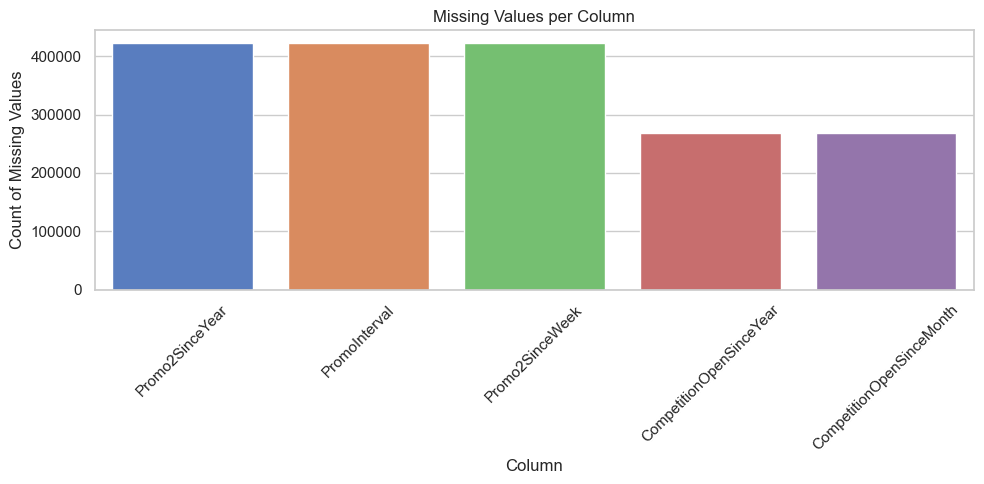

In [8]:
# Target columns
cols_to_check = ['Promo2SinceYear', 'PromoInterval', 'Promo2SinceWeek',
                 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

# Count missing values
missing_counts = df[cols_to_check].isnull().sum()
missing_df = missing_counts[missing_counts > 0].sort_values(ascending=False).reset_index()
missing_df.columns = ['Column', 'MissingValues']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Column', y='MissingValues', data=missing_df, palette='muted')
plt.title('Missing Values per Column')
plt.ylabel('Count of Missing Values')
plt.xlabel('Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Null handling for Promo2SinceYear, Promo2SinceWeek, PromoInterval

- For stores with Promo2 == 1, we impute safe defaults in Promo2SinceYear and Promo2SinceWeek to allow type conversion. 
  
- Then we compute Promo2Start as a date, calculate promo duration in weeks, and set duration to 0 for inactive stores.

In [9]:
# Only run for rows where Promo2 == 1
promo2_rows = df['Promo2'] == 1

# Convert to integers safely
df.loc[promo2_rows, 'Promo2SinceYear'] = df.loc[promo2_rows, 'Promo2SinceYear'].fillna(0).astype(int)
df.loc[promo2_rows, 'Promo2SinceWeek'] = df.loc[promo2_rows, 'Promo2SinceWeek'].fillna(1).astype(int)

# Convert Promo2SinceWeek to a start-of-week date

# Updated function using ISO week logic
def week_to_date(year, week):
    try:
        return pd.to_datetime(f'{int(year)}-{int(week)}-1', format='%G-%V-%u')
    except:
        return pd.NaT

df['Promo2Start'] = df.apply(
    lambda row: week_to_date(row['Promo2SinceYear'], row['Promo2SinceWeek']) if row['Promo2'] == 1 else pd.NaT,
    axis=1
)

# Calculate duration in weeks (or days)
df['Promo2DurationWeeks'] = (df['Date'] - df['Promo2Start']).dt.days // 7

# fill NaN durations with 0 where Promo2 is inactive
df['Promo2DurationWeeks'] = df['Promo2DurationWeeks'].where(df['Promo2'] == 1, 0)

In [10]:
df['Promo2Start'].info()
df['Promo2Start'].head(10)

<class 'pandas.core.series.Series'>
Index: 844338 entries, 0 to 1017190
Series name: Promo2Start
Non-Null Count   Dtype         
--------------   -----         
421046 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 45.1 MB


0          NaT
1   2010-03-29
2   2011-04-04
3          NaT
4          NaT
5          NaT
6          NaT
7          NaT
8          NaT
9          NaT
Name: Promo2Start, dtype: datetime64[ns]

#### Null handling for CompetitionOpenSinceYear, CompetitionOpenSinceMonth

- Handle missing values in competition-related fields. If either component of the open date is missing, we impute the missing part with the median or a fallback and reconstruct the full competition open date.

In [11]:
# Encode low-cardinality integer columns (safe handling of NaNs)
label_cols = ['DayOfWeek', 'Promo2SinceYear']
for col in label_cols:
    df[col] = df[col].fillna(-1).astype('int64')  # -1 = missing

# Create datetime column 'CompetitionOpenSince'
df['CompetitionOpenSince'] = pd.to_datetime(
    dict(
        year=df['CompetitionOpenSinceYear'],
        month=df['CompetitionOpenSinceMonth'],
        day=1
    ),
    errors='coerce'  # Convert invalid entries to NaT
)

# Find earliest date in the dataset per store
store_start = df.groupby('Store')['Date'].min().rename('StoreStartDate').reset_index()

# Merge that back into main df
df = df.merge(store_start, on='Store', how='left')

# Fill missing CompetitionOpenSince with StoreStartDate
df['CompetitionOpenSince'] = df['CompetitionOpenSince'].fillna(df['StoreStartDate'])

# Compute duration in months
df['CompetitionOpenDuration'] = (
    (df['Date'] - df['CompetitionOpenSince']).dt.days // 30
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Promo                      844338 non-null  int64         
 5   StateHoliday               844338 non-null  string        
 6   SchoolHoliday              844338 non-null  int64         
 7   StoreType                  844338 non-null  string        
 8   Assortment                 844338 non-null  string        
 9   CompetitionDistance        842152 non-null  float64       
 10  CompetitionOpenSinceMonth  575738 non-null  float64       
 11  CompetitionOpenSinceYear   575738 non-null  float64 

#### Null Handling for PromoInterval and CompetitionDistance

- We drop `PromoInterval` because its meaning is redundant with existing `Promo2`, `Promo2SinceWeek`, and `Promo2SinceYear` fields. Most of its values are missing for non-participating stores (where Promo2 == 0), and the remaining information is already captured in the constructed `Promo2Start` and `Promo2DurationWeeks`.

- For `CompetitionDistance`, we impute missing values using the median. This avoids introducing outliers or bias into the model, since the missing values are rare (~0.2% of rows) and unlikely to carry a specific signal. Imputing with the median preserves distributional stability and avoids skewing model behavior.


In [12]:
# Drop 'PromoInterval' — redundant with Promo2 logic
df.drop(columns=['PromoInterval'], inplace=True)

# Impute missing CompetitionDistance with median value
median_distance = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(median_distance)

### Feature encoding

- Prepare for encoding by inspecting feature cardinality. This step informs the choice between one-hot encoding, label encoding, or grouping of rare categories.

#### Feature cardinality

- Display the number of unique values for each feature. Features with low cardinality are good candidates for one-hot encoding, while high-cardinality features may require alternative strategies.

In [13]:
df.nunique()

Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21733
Promo                            2
StateHoliday                     4
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            654
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 50
Promo2SinceYear                  8
Year                             3
Month                           12
Day                             31
Week                            52
IsWeekend                        2
Promo2Start                    150
Promo2DurationWeeks            314
CompetitionOpenSince           174
StoreStartDate                   5
CompetitionOpenDuration        376
dtype: int64

#### Label encode low-cardinality numeric categorical columns

- We encode numeric categorical features with a small number of discrete values ( DayOfWeek, Promo2SinceYear) by casting them to int64. 
  
  - Missing values are filled with -1 to preserve numerical format while signaling "missing" in a way that models can interpret. 
  
  - This avoids issues with NaNs during modeling while preserving ordinal or numeric meaning where applicable.

In [14]:
# Label encode simple binary or low-card columns (already 0/1 or small integers)
label_cols = [
    'DayOfWeek',         # 1–7
    'Promo2SinceYear'    # up to 8 unique values
]

for col in label_cols:
    # Fill NaNs with -1 to safely cast to int
    df[col] = df[col].fillna(-1).astype('int64')  # -1 means "missing"

In [15]:
zero_open = df[(df["Sales"] == 0)]
print(f"Zero-sales total (regardless of open/closed): {len(zero_open)}")

Zero-sales total (regardless of open/closed): 0


#### Encode IsStateHoliday column to binary 
- Convert the StateHoliday column into a binary format, mapping '0' to 0 (not a holiday) and other holiday types ('a', 'b', 'c') to 1. This simplifies sparse holiday categories into a single binary feature to capture their overall impact on sales. 
  
- Rename SchoolHoliday to IsSchoolHoliday for naming consistency.

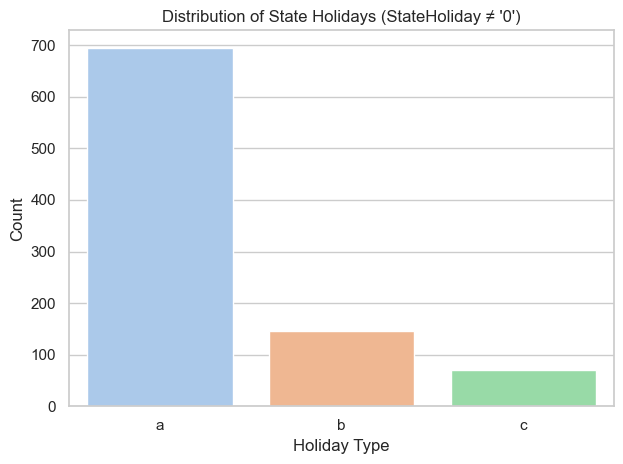

In [16]:
# Filter out non-holidays
holiday_df = df[df['StateHoliday'] != '0']

# Plot
sns.countplot(x='StateHoliday', data=holiday_df, palette='pastel')
plt.title("Distribution of State Holidays (StateHoliday ≠ '0')")
plt.xlabel("Holiday Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [17]:
# Encode StateHoliday as binary IsStateHoliday column
df['IsStateHoliday'] = df['StateHoliday'].apply(lambda x: 0 if x == '0' else 1)

# Rename SchoolHoliday -> IsSchoolHoliday for consistency
df.rename(columns={'SchoolHoliday': 'IsSchoolHoliday'}, inplace=True)

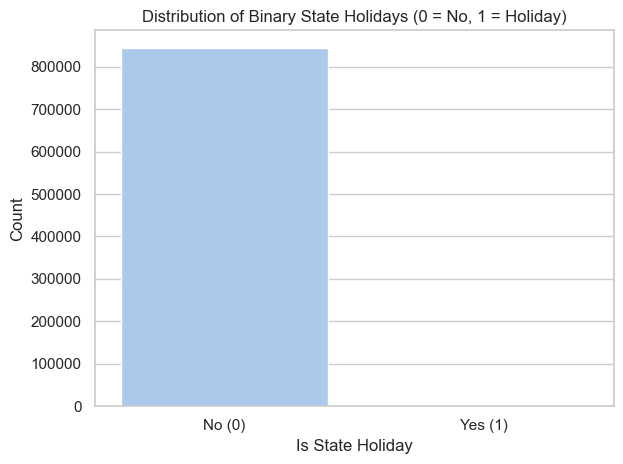

In [18]:
# Plot distribution of binary StateHoliday values
sns.countplot(x='IsStateHoliday', data=df, palette='pastel')
plt.title("Distribution of Binary State Holidays (0 = No, 1 = Holiday)")
plt.xlabel("Is State Holiday")
plt.ylabel("Count")
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])  
plt.tight_layout()
plt.show()

#### Label-encode structured categorical features for tree-based models

- Convert features like weeks, months, and opening dates into numeric format using LabelEncoder. 
  
  - While some of these columns have an inherent order (Month, Week), we apply label encoding for simplicity and compatibility with tree-based models (XGBoost). 
  
  - Inputs are cast to string to ensure consistent encoding, even for integer-based columns with missing or irregular values.

In [19]:
# Columns to label encode
ordinal_cols = [
    'Promo2SinceWeek', 
    'CompetitionOpenSinceMonth', 
    'CompetitionOpenSinceYear', 
    'Week', 
    'Day', 
]

# Apply Label Encoding - cast to string for consistent encoding 
le = LabelEncoder()
for col in ordinal_cols:
    df[col] = le.fit_transform(df[col].astype(str))

## Section 3: Data exploration
---

- Perform exploratory analysis to understand data structure, identify potential issues, and begin recognizing key trends. This includes inspecting data types, missing values, date ranges, sales distribution, and temporal patterns.

### Basic inspection

- Confirm latest format of updated dataframe.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Promo                      844338 non-null  int64         
 5   StateHoliday               844338 non-null  string        
 6   IsSchoolHoliday            844338 non-null  int64         
 7   StoreType                  844338 non-null  string        
 8   Assortment                 844338 non-null  string        
 9   CompetitionDistance        844338 non-null  float64       
 10  CompetitionOpenSinceMonth  844338 non-null  int64         
 11  CompetitionOpenSinceYear   844338 non-null  int64   

In [21]:
df.describe()

,Store,DayOfWeek,Date,Sales,Promo,IsSchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,Week,IsWeekend,Promo2Start,Promo2DurationWeeks,CompetitionOpenSince,StoreStartDate,CompetitionOpenDuration,IsStateHoliday
count,"844,338.00","844,338.00",844338,"844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00","844,338.00",421046,"844,338.00",844338,844338,"844,338.00","844,338.00"
mean,558.42,2.52,2014-04-11 01:08:38.729702912,"6,955.96",0.45,0.19,"5,450.03",7.93,18.15,0.50,35.10,"1,002.66","2,013.83",5.85,14.89,23.89,0.17,2012-01-23 17:13:56.220270336,57.10,2010-06-03 06:34:41.007369216,2013-01-02 09:10:15.020999424,46.44,0.00
min,1.00,0.00,2013-01-01 00:00:00,46.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,-1.00,"2,013.00",1.00,0.00,0.00,0.00,2009-07-27 00:00:00,0.00,1900-01-01 00:00:00,2013-01-01 00:00:00,-32.00,0.00
25%,280.00,1.00,2013-08-16 00:00:00,"4,859.00",0.00,0.00,710.00,5.00,15.00,0.00,19.00,-1.00,"2,013.00",3.00,7.00,11.00,0.00,2011-02-28 00:00:00,0.00,2008-03-01 00:00:00,2013-01-02 00:00:00,10.00,0.00
50%,558.00,2.00,2014-03-31 00:00:00,"6,369.00",0.00,0.00,"2,320.00",9.00,19.00,0.00,50.00,-1.00,"2,014.00",6.00,15.00,22.00,0.00,2012-04-02 00:00:00,0.00,2012-11-01 00:00:00,2013-01-02 00:00:00,26.00,0.00
75%,837.00,4.00,2014-12-11 00:00:00,"8,360.00",1.00,0.00,"6,880.00",12.00,23.00,1.00,50.00,"2,012.00","2,014.00",8.00,22.00,37.00,0.00,2013-03-04 00:00:00,108.00,2013-01-02 00:00:00,2013-01-02 00:00:00,74.00,0.00
max,"1,115.00",6.00,2015-07-31 00:00:00,"41,551.00",1.00,1.00,"75,860.00",12.00,23.00,1.00,50.00,"2,015.00","2,015.00",12.00,30.00,51.00,1.00,2015-06-01 00:00:00,313.00,2015-08-01 00:00:00,2013-07-05 00:00:00,"1,407.00",1.00
std,321.73,1.72,NaN,"3,103.82",0.50,0.40,"7,801.09",3.96,4.90,0.50,18.63,"1,006.33",0.78,3.32,8.89,15.33,0.38,NaN,82.31,NaN,NaN,64.36,0.03


In [22]:
df.head()

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,IsSchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,Week,IsWeekend,Promo2Start,Promo2DurationWeeks,CompetitionOpenSince,StoreStartDate,CompetitionOpenDuration,IsStateHoliday
0,1,4,2015-07-31,5263,1,0,1,c,a,"1,270.00",11,15,0,50,-1,2015,7,24,24,0,NaT,0.00,2008-09-01,2013-01-02,84,0
1,2,4,2015-07-31,6064,1,0,1,a,a,570.00,2,14,1,4,2010,2015,7,24,24,0,2010-03-29,278.00,2007-11-01,2013-01-02,94,0
2,3,4,2015-07-31,8314,1,0,1,a,a,"14,130.00",3,13,1,5,2011,2015,7,24,24,0,2011-04-04,225.00,2006-12-01,2013-01-02,105,0
3,4,4,2015-07-31,13995,1,0,1,c,c,620.00,11,16,0,50,-1,2015,7,24,24,0,NaT,0.00,2009-09-01,2013-01-02,71,0
4,5,4,2015-07-31,4822,1,0,1,a,a,"29,910.00",6,22,0,50,-1,2015,7,24,24,0,NaT,0.00,2015-04-01,2013-01-02,4,0


### Data consistency

- We observe a dip in the number of daily records during part of the time series—likely due to store closures or incomplete reporting — we will address this in a later section by accounting for the number of active stores per day to ensure fair normalization of sales figures across time.


Start date: 2013-01-01 00:00:00
End date: 2015-07-31 00:00:00
Date range: 941 days 00:00:00


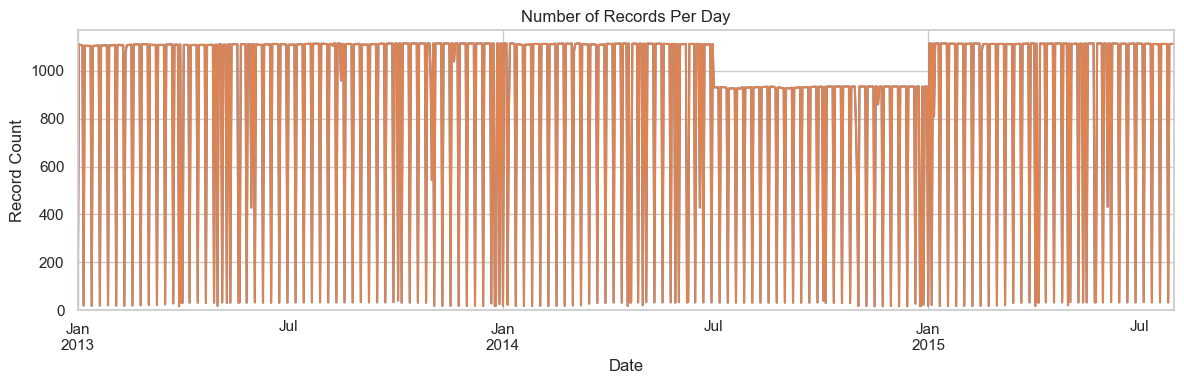

In [23]:
print("Start date:", df['Date'].min())
print("End date:", df['Date'].max())
print("Date range:", (df['Date'].max() - df['Date'].min()))
df['Date'].value_counts().sort_index().plot()


df['Date'].value_counts().sort_index().plot(figsize=(12, 4))
plt.title("Number of Records Per Day")
plt.xlabel("Date")
plt.ylabel("Record Count")
plt.ylim(0)  
plt.tight_layout()
plt.show()

### Sales

- Plot the average sales per store to examine cross-store variability. This reveals how store performance is distributed and whether some stores consistently underperform or dominate sales volume.

#### Sales distribution

- Visualize the average sales per store and the raw daily sales.
  
- The histograms shows strong right skew, confirming that many stores make low sales and only a few achieve very high values. This informs potential transformations.

Text(0.5, 1.0, 'Avg Sales Per Store')

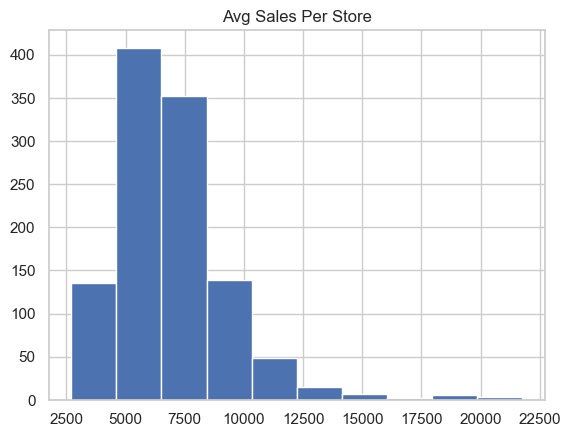

In [24]:
# Average sales (in currency units) for all stores 
df.groupby('Store')['Sales'].mean().hist()
plt.title("Avg Sales Per Store")

Text(0.5, 1.0, 'Sales Distribution')

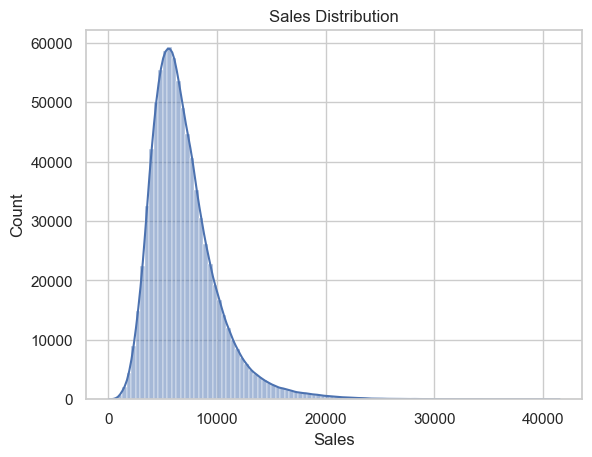

In [25]:
# Actual sales numbers
sns.histplot(df['Sales'], bins=100, kde=True)
plt.title("Sales Distribution")

#### Average overall sales by date 

- Plot the daily average sales across all stores, applying LOWESS smoothing to reveal seasonality and temporal trends. This helps identify sales peaks (holidays or promotions) and long-term cycles that may influence forecasting.
  
- The LOWESS-smoothed line reveals several recurring peaks in average daily sales, suggesting strong seasonality effects. These spikes likely align with major holidays or promotional events.

- We also observe a generally stable sales level between peaks, indicating that most stores maintain consistent performance outside of promotional periods. 

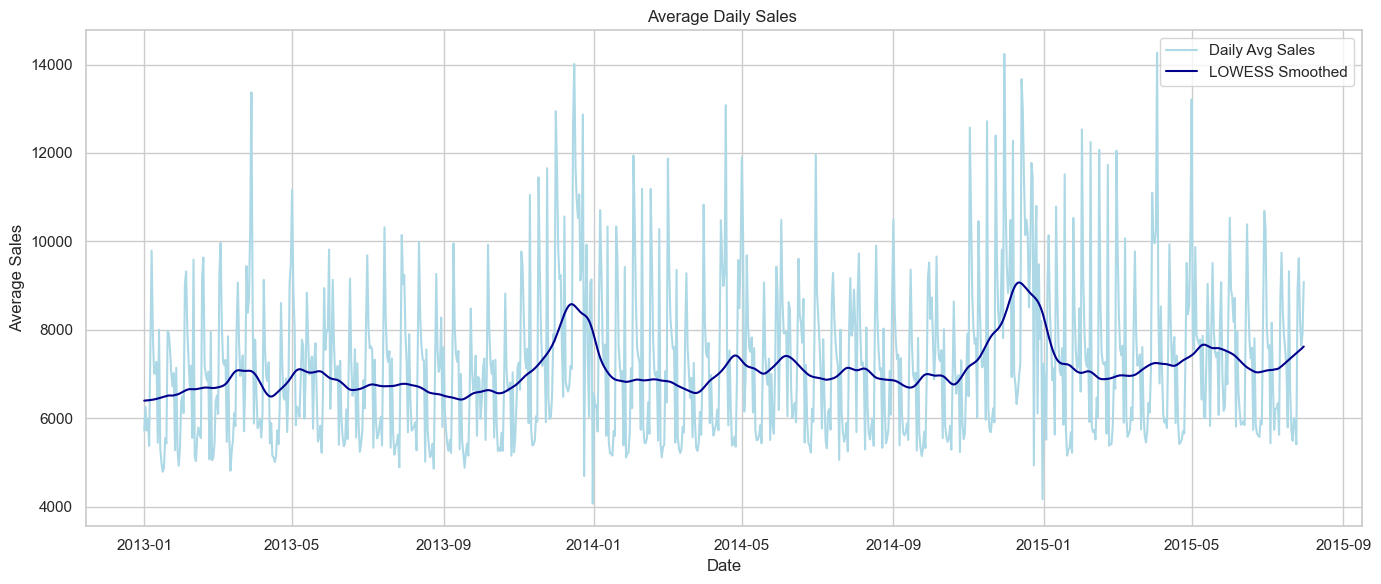

In [26]:
# Group sales by date 
daily_avg = df.groupby('Date')['Sales'].mean().reset_index()

# Apply LOWESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(daily_avg['Sales'], daily_avg['Date'], frac=0.05)  # frac adjusts smoothness

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_avg, x='Date', y='Sales', color='lightblue', label='Daily Avg Sales')
plt.plot(daily_avg['Date'], smoothed[:, 1], color='darkblue', label='LOWESS Smoothed')
plt.title("Average Daily Sales ")
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Section 4: Store-level insights
---

Average sales by store

Sales over time for a few example stores

Store type distribution

Competition distance distribution

### Store type

#### Distribution of store types 

- Store type 'a' dominates the dataset, accounting for the majority of entries. Store types 'c' and 'd' appear significantly less frequently, while 'b' is rare. 
  
  - This class imbalance should be kept in mind for modeling and interpretation, especially if store type is used as a feature — models may overweight patterns found in the dominant type. It may also be helpful to explore whether store performance varies significantly by type.

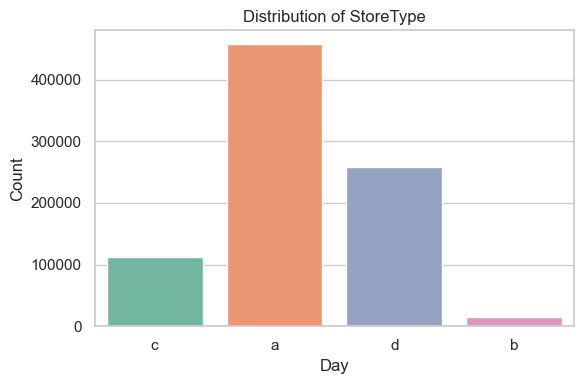

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['StoreType'], data=df, palette="Set2")
plt.title('Distribution of StoreType')
plt.xlabel(col)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Top 20 performing stores by average sales 

- This bar chart highlights the top 20 stores with the highest average daily sales. 
  
  - Store 817 stands out as a clear leader, significantly outperforming all others.
  
  - Most other top-performing stores cluster between 12,000 and 18,000 in average sales, suggesting a small subset of stores drive a disproportionate share of overall revenue. 
  
  - This distribution may indicate regional effects, store format advantages, or localized customer behavior — all of which warrant further investigation. 


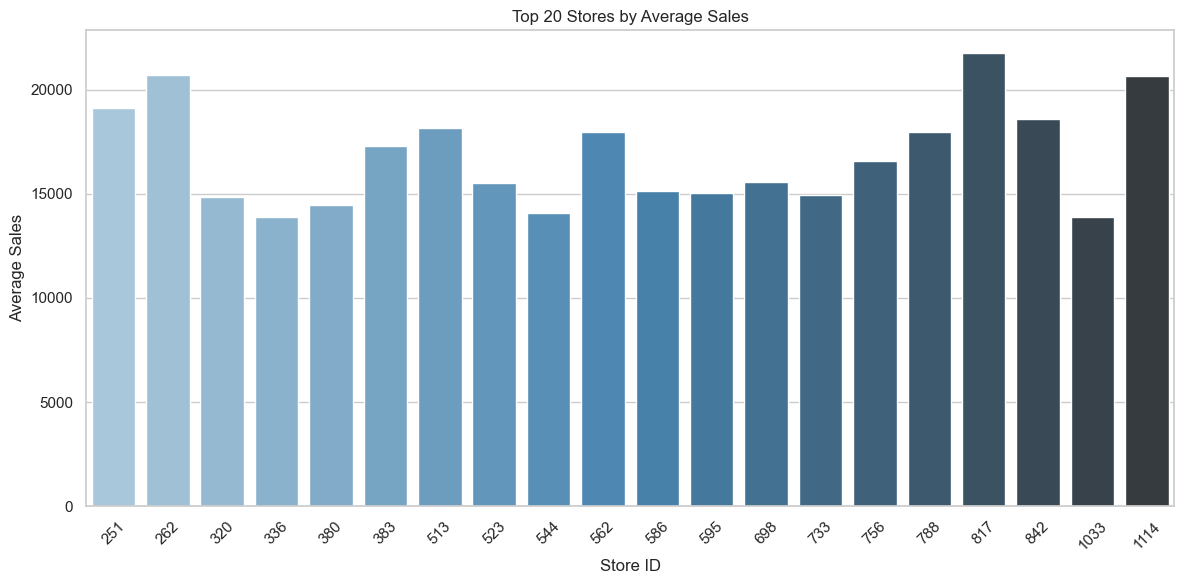

In [28]:
top_n = 20
avg_sales_by_store = df.groupby('Store')['Sales'].mean().sort_values(ascending=False).head(top_n).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sales_by_store, x='Store', y='Sales', palette='Blues_d')
plt.title(f'Top {top_n} Stores by Average Sales')
plt.xlabel('Store ID')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Sales of each type of store 

- The first boxplot shows the full distribution of daily sales for each store type, highlighting outliers and spread.
  
  - Store type b clearly exhibits the highest median and widest variability in sales, while types a, c, and d show similar, more modest distributions.

- The second chart summarizes these results using mean sales and standard deviation. 
  
  - Again, store type b leads in average performance, with a substantially higher mean and wider standard deviation, indicating more volatile but potentially more profitable behavior.


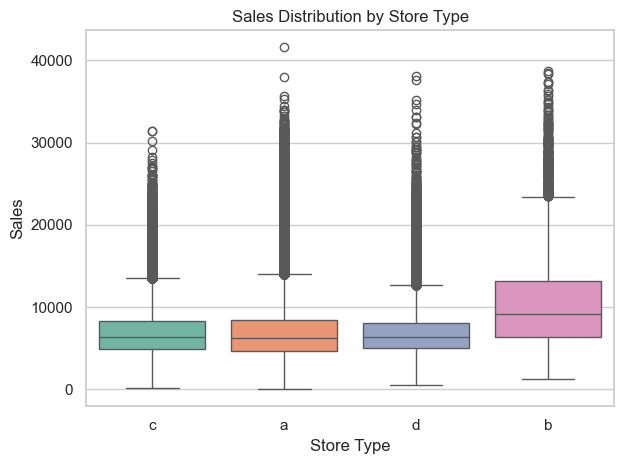

In [29]:
sns.boxplot(x='StoreType', y='Sales', data=df, palette='Set2')
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

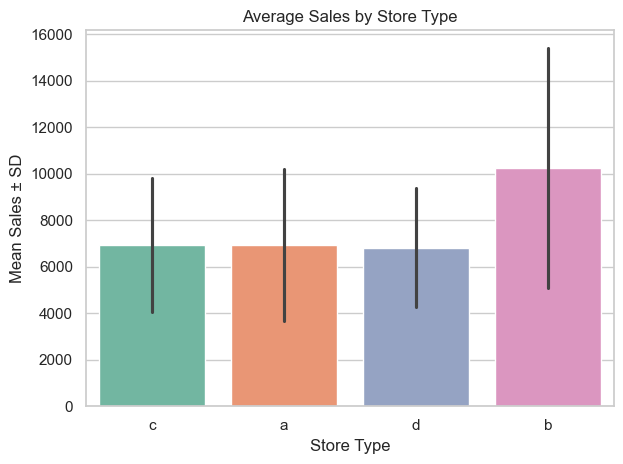

In [30]:
sns.barplot(x='StoreType', y='Sales', data=df, estimator='mean', ci='sd', palette='Set2')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Mean Sales ± SD')
plt.tight_layout()
plt.show()

#### Count of each type of store

- This plot shows the distribution of store types in the dataset. Store type a is by far the most common, followed by d, c, and a small number of type b stores.

- When viewed in context with the earlier sales plots:
  
  - Type b stores are rare but exhibit the highest average sales and largest spread, suggesting they are high-performing, high-variance locations.
  
  - Type a stores dominate in count but have moderate average sales. Types c and d have similar mid-range sales performance.

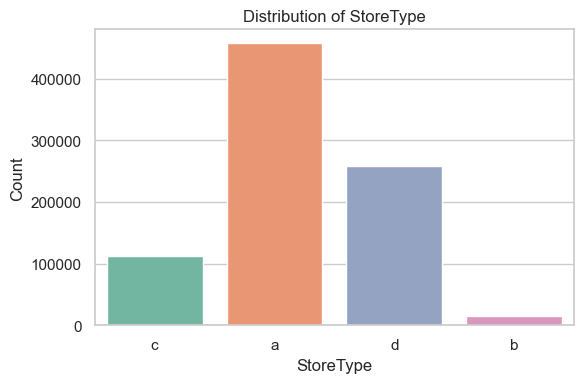

In [31]:
# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='StoreType', data=df, palette='Set2')
plt.title('Distribution of StoreType')
plt.xlabel('StoreType')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Assortment

- The majority of stores fall under assortment types 'a' and 'c', with type 'b' being extremely rare. 
  
  - Despite its low representation, assortment type 'b' has the highest average sales and a visibly higher sales distribution. 
  
  - This suggests that type 'b' assortments may be strategically used in high-performing locations or target specific customer segments that yield higher revenue.


- Assortments 'a' and 'c' have similar average sales and distributions, but given their large volume, they may represent standard offerings. 
  
  - The wide standard deviations across all types indicate considerable variability in store performance within each assortment category, especially in type 'b', which shows both high mean and high variance.
  

- This pattern may suggest that assortment type 'b' is reserved for select stores with greater revenue potential, while 'a' and 'c' serve as more generalized configurations. 

#### Distribution of assortment types 

Text(0.5, 1.0, 'Distribution of Assortment Types')

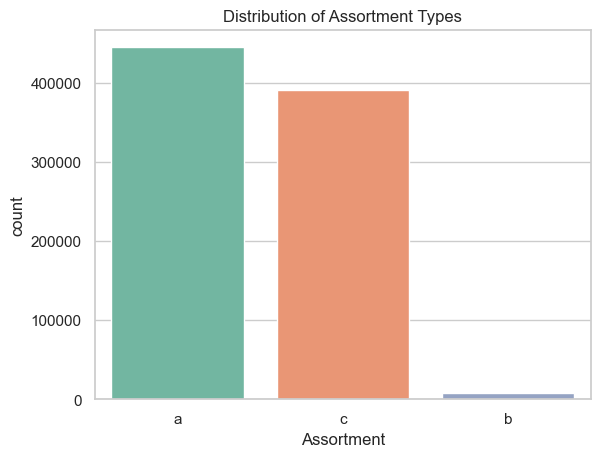

In [32]:
sns.countplot(x='Assortment', data=df, palette='Set2')
plt.title('Distribution of Assortment Types')

#### Sales by assortment

Text(0.5, 1.0, 'Sales Distribution by Assortment Type')

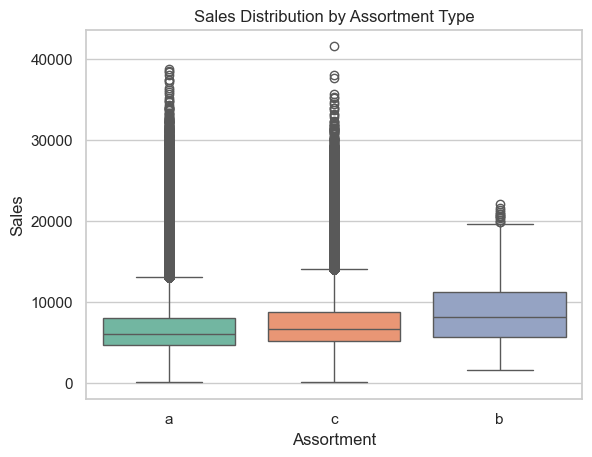

In [33]:
sns.boxplot(x='Assortment', y='Sales', data=df, palette='Set2')
plt.title('Sales Distribution by Assortment Type')

#### Average sales by assortment

Text(0.5, 1.0, 'Average Sales by Assortment Type')

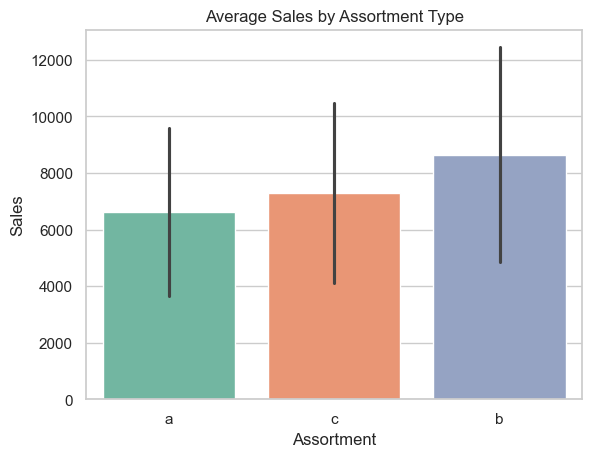

In [34]:
sns.barplot(x='Assortment', y='Sales', data=df, estimator='mean', ci='sd', palette='Set2')
plt.title('Average Sales by Assortment Type')

### Competition distance

- These visualizations explore how competition distance varies by store type and how it correlates with sales performance.

  - The KDE plot shows that most stores are located close to competitors, regardless of type, though the degree of clustering varies.
  
  - The boxplot confirms this clustering but also reveals that Store Types a, c, and d have wider interquartile ranges and more extreme outliers, suggesting more geographic diversity, including rural or sparsely populated regions.

- Store Type b is distinct:
  
  - It has a sharp KDE peak near zero and a tight boxplot distribution, indicating consistent placement in areas of dense competition.

  - Rather than being negatively affected, these stores may actually benefit from this setup—likely operating in busy commercial zones where high foot traffic and dense retail clusters help drive sales despite proximity to rivals.

- The scatter plot of Sales vs. Competition Distance further supports this interpretation:
  
  - Stores with very short competition distances achieve high sales figures, reinforcing the idea that being near competitors is actually beneficial.
  
  - This may reflect advantages of urban placement — visibility and foot traffic outweighing the risks of competition.

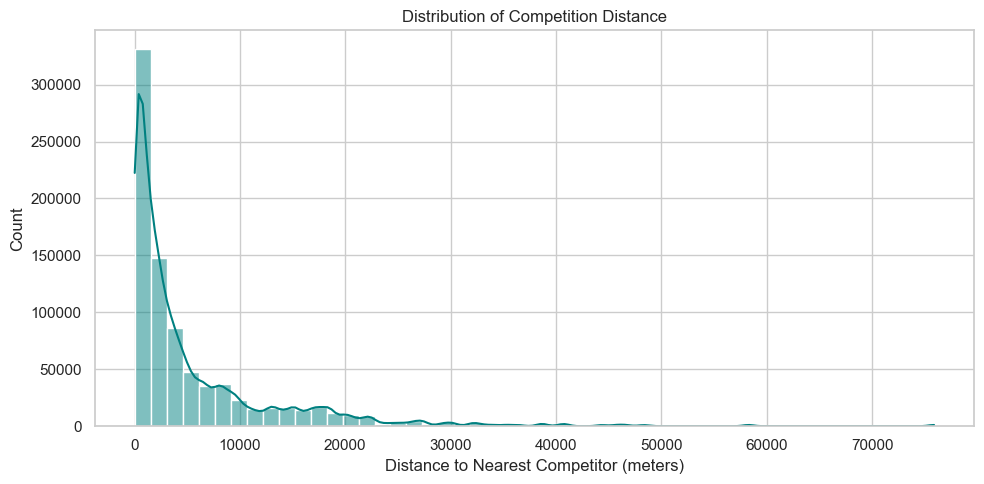

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(df['CompetitionDistance'].dropna(), bins=50, kde=True, color='teal')
plt.title('Distribution of Competition Distance')
plt.xlabel('Distance to Nearest Competitor (meters)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

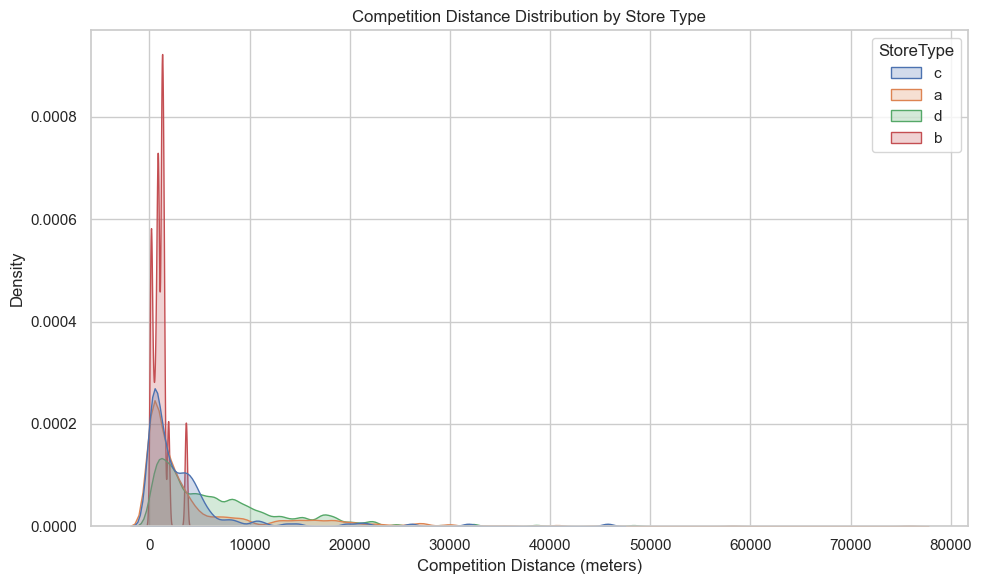

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='CompetitionDistance', hue='StoreType', common_norm=False, fill=True)
plt.title('Competition Distance Distribution by Store Type')
plt.xlabel('Competition Distance (meters)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

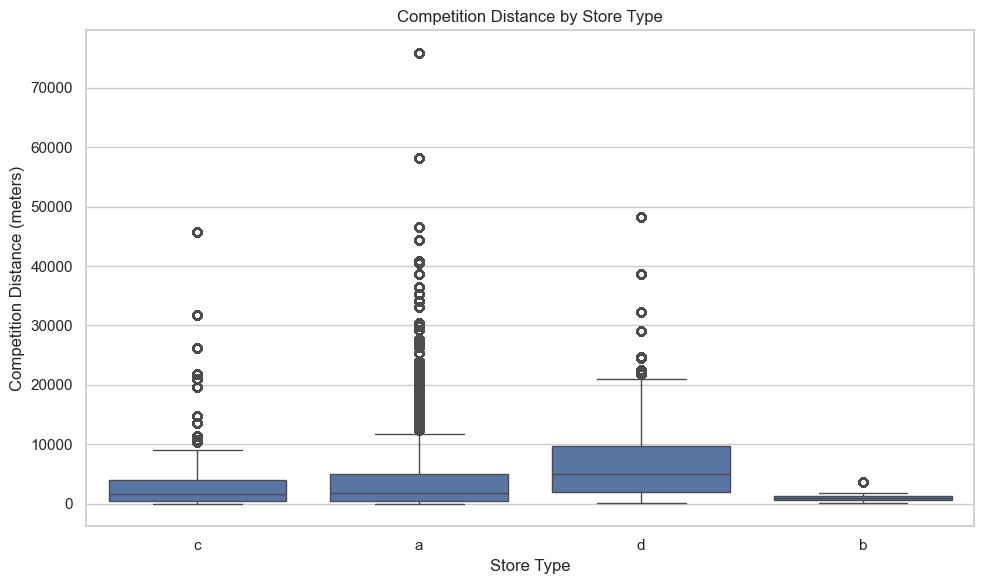

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='CompetitionDistance', data=df)
plt.title('Competition Distance by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Competition Distance (meters)')
plt.tight_layout()
plt.show()

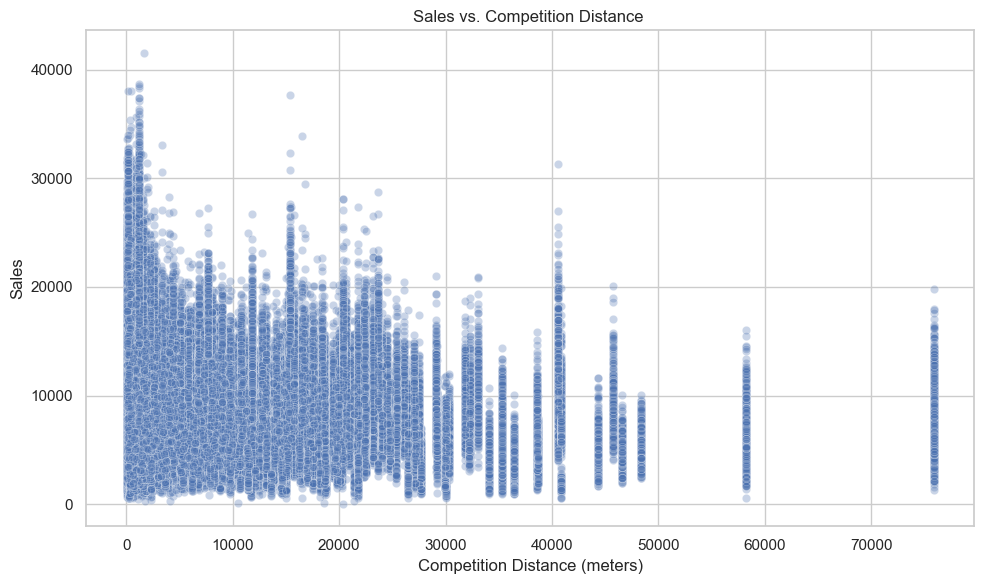

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df, alpha=0.3)
plt.title('Sales vs. Competition Distance ')
plt.xlabel('Competition Distance (meters)')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

## Section 5: Promotions and holidays
---

- In this section, we examine how promotional campaigns and holiday schedules—particularly school holidays—impact store sales. 

- We assess distributional differences, evaluate statistical significance, and explore possible explanations for observed patterns. 
  
- This analysis helps identify how external events and marketing efforts influence customer behavior and purchasing volume.

- Filtering for only open days ensures that we analyze the effects of these time-related features on days where sales are actually possible. 


### Promo / Promo2

#### Distribution of Promo / Promo2 (Open Days Only)

- The `Promo` feature (indicating a periodic, short-term promotional event) is active on a significant portion of open days, but not the majority.
  
- The `Promo2` feature (a long-term, continuous promotional program) is roughly balanced, with nearly half of the open days showing participation.

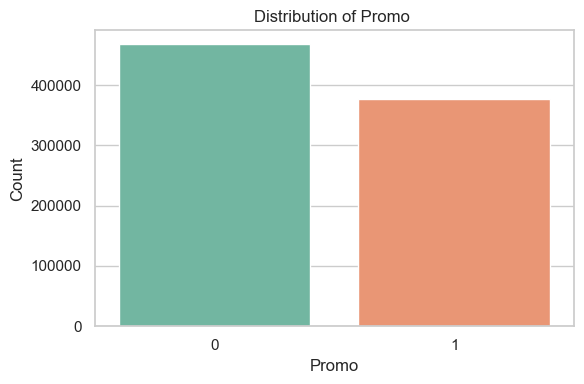

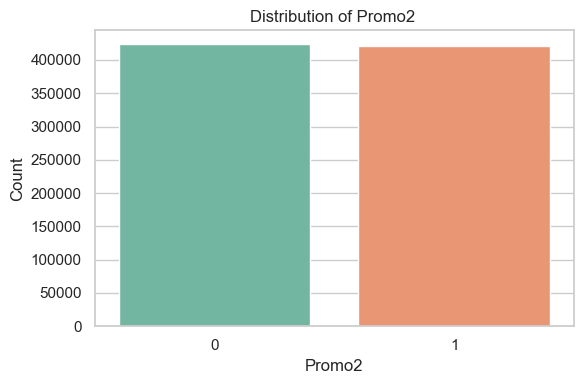

In [39]:
promo_cols = ['Promo', 'Promo2']

for col in promo_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, palette="Set2")
    plt.title(f'Distribution of {col} ')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

#### Promo trends over time 

- Promo days (short-term promotional events) show clear fluctuations month-to-month, with noticeable seasonal spikes—particularly in early 2015 suggesting that promotions are timed to specific campaigns or business cycles.

- In contrast, Promo2 (longer-running, scheduled promotions) maintains a much more stable monthly pattern. Apart from a significant drop in mid-2014, the proportion of Promo2 days hovers steadily around 50%, reinforcing its nature as a persistent, programmatic promotion type.

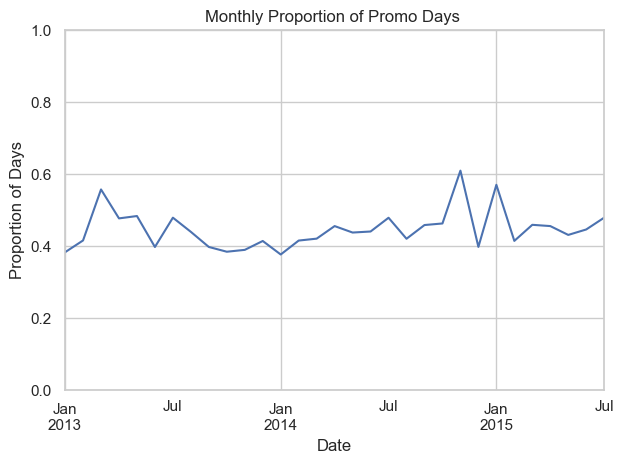

In [40]:
# Promo plot
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date').resample('M')['Promo'].mean().plot()
plt.ylim(0, 1)  # Set y-axis to range from 0 to 1
plt.title('Monthly Proportion of Promo Days ')
plt.xlabel('Date')
plt.ylabel('Proportion of Days')
plt.tight_layout()
plt.show()

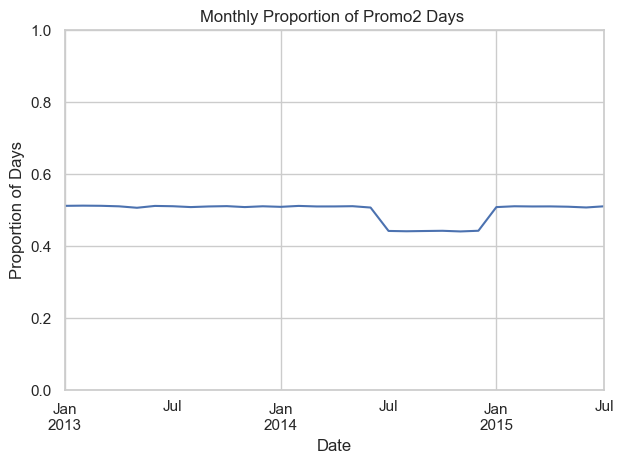

In [41]:
# Promo2 pot
df.set_index('Date').resample('M')['Promo2'].mean().plot()
plt.ylim(0, 1)  # Set y-axis to range from 0 to 1
plt.title('Monthly Proportion of Promo2 Days ')
plt.xlabel('Date')
plt.ylabel('Proportion of Days')
plt.tight_layout()
plt.show()

#### Impact of promos on sales 

- To evaluate how promotions influence store sales on days when stores are open, we compare sales distributions with and without promotions using violin and box plots.

	- Promo (Standard Promotion)
		
		- The first violin plot shows a clear shift in the sales distribution between days with Promo = 0 and Promo = 1. 
  
    		- Stores running a standard promotion tend to have a higher median sales value and higher IQR, as well as more density for higher sales values, strongly suggesting that the standard promotion is associated with a meaningful boost in sales volume.

	- Promo2 (Ongoing Promotion Campaign)
	
		- The boxplot comparing Promo2 = 0 vs Promo2 = 1 shows minimal difference in both median and IQR (interquartile range). 
  
    		- While there are outliers in both groups, the central distribution remains largely unchanged. There is a slight difference that suggests sales are actually greater when Promo2 is inactive. 

		- This implies that Promo2, on its own, does not appear to significantly impact daily sales, at least not in a way that's consistently detectable in the aggregated data.

Text(0.5, 1.0, 'Sales Distribution with/without Promo ')

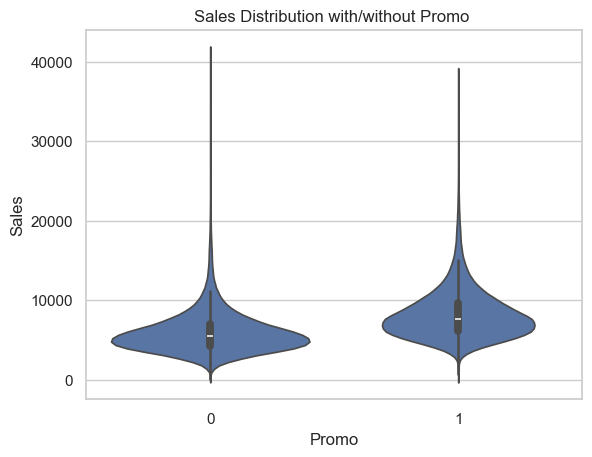

In [42]:
sns.violinplot(x='Promo', y='Sales', data=df)
plt.title('Sales Distribution with/without Promo ')

Text(0.5, 1.0, 'Sales Distribution with/without Promo2 ')

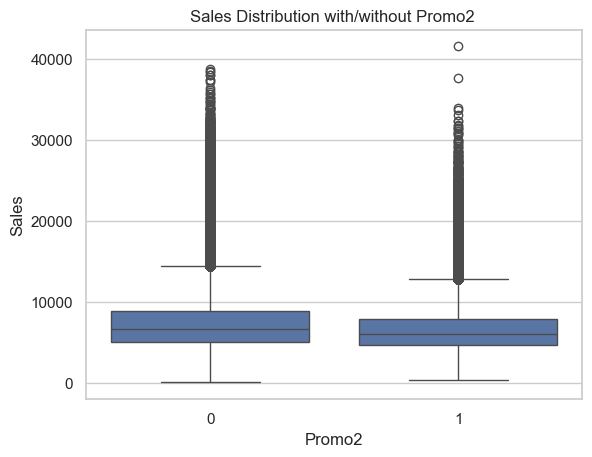

In [43]:
sns.boxplot(x='Promo2', y='Sales', data=df)
plt.title('Sales Distribution with/without Promo2 ')

In [44]:
df['Sales'].describe()

count   844,338.00
mean      6,955.96
std       3,103.82
min          46.00
25%       4,859.00
50%       6,369.00
75%       8,360.00
max      41,551.00
Name: Sales, dtype: float64

#### Impact of promos on sales (average sales)

- To evaluate the impact of promotional campaigns on sales, we analyze average sales for open stores based on the presence of Promo and Promo2.

- Promo (standard promotion) shows a clear positive effect on sales.

  - Average sales with Promo == 1 are significantly higher than when no promotion is active.

  - This confirms that promotional campaigns are associated with a substantial increase in sales volume.

- Promo2 (alternate promotion) shows a slightly negative effect.

  - Surprisingly, stores with Promo2 == 1 have lower average sales than those without.

  - However, this inverse effect is modest and may reflect underlying factors such as promotion fatigue, seasonality, or store-specific dynamics.

Text(0.5, 1.0, 'Average Sales with/without Promo ')

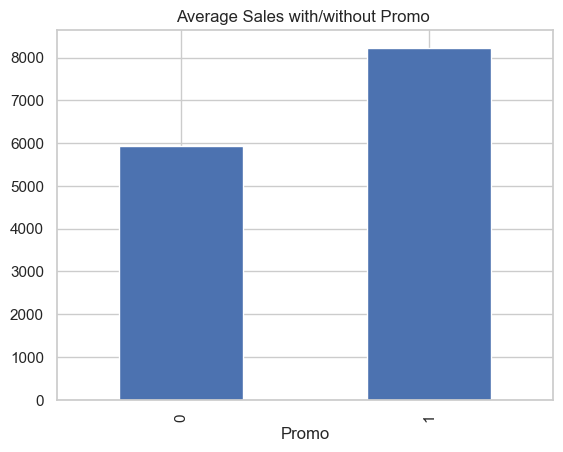

In [45]:
df.groupby('Promo')['Sales'].mean().plot(kind='bar')
plt.title('Average Sales with/without Promo ')

Text(0.5, 1.0, 'Average Sales with/without Promo2 ')

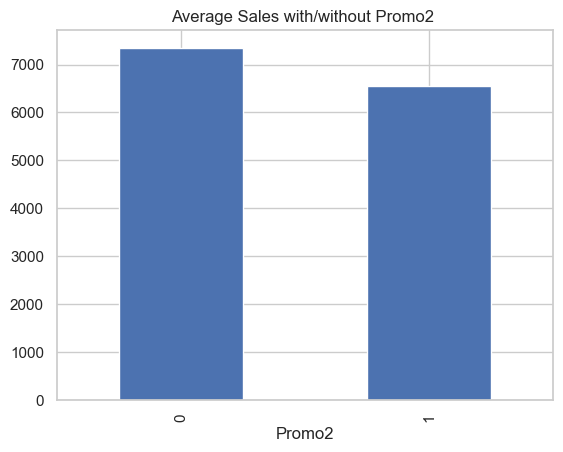

In [46]:
df.groupby('Promo2')['Sales'].mean().plot(kind='bar')
plt.title('Average Sales with/without Promo2 ')

### Holidays

#### Impact of state holidays 

- It is clear that the overwhelming majority of stores are closed on state holidays (~0.1% of data points represent holidays where stores are open). This will be addressed in the 'Feature Engineering' section below. 

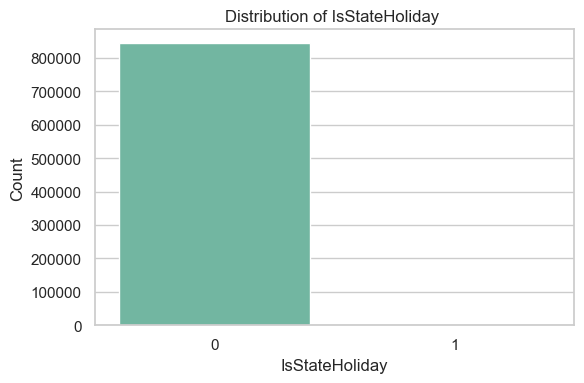

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['IsStateHoliday'], data=df, palette="Set2")
plt.title(f'Distribution of IsStateHoliday ')
plt.xlabel('IsStateHoliday')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [48]:
print("State Holiday Counts ", df['IsStateHoliday'].value_counts())
print("School Holiday Counts ", df['IsSchoolHoliday'].value_counts())

State Holiday Counts  IsStateHoliday
0    843428
1       910
Name: count, dtype: int64
School Holiday Counts  IsSchoolHoliday
0    680893
1    163445
Name: count, dtype: int64


### Statistical Test: School Holiday vs Non-Holiday Sales

To determine whether sales differ significantly between school holidays and non-holidays, we performed an independent two-sample t-test using `scipy.stats.ttest_ind`.

- We used Welch’s t-test by setting `equal_var=False`.
  
  - A z-test was not used because population standard deviations are unknown.
  
  - The sample sizes and standard deviations differ between groups, which violates the assumption of equal variances.
  
  - Welch’s t-test does not assume equal variances and adjusts the degrees of freedom accordingly.
  
  - Each group contains over 100,000 samples, so the sampling distribution of the mean is approximately normal due to the Central Limit Theorem.
  
    - This indicates the t-test is the appropriate choice.
  
  - Observations are independent because each row represents a separate store-date combination.
  
- The resulting t-statistic was 34.87 and the p-value was smaller than 1e-250.

  - This means the difference in average sales between holidays and non-holidays is statistically significant.

- We conclude that school holidays are associated with meaningful changes in sales.


In [49]:
# Group by school holiday status and calculate mean and standard deviation
summary_stats = df.groupby('IsSchoolHoliday')['Sales'].agg(['mean', 'std', 'count']).reset_index()

# Print the numeric summary
print(summary_stats)

sales_holiday = df[df['IsSchoolHoliday'] == 1]['Sales']
sales_non_holiday = df[df['IsSchoolHoliday'] == 0]['Sales']

t_stat, p_value = ttest_ind(sales_holiday, sales_non_holiday, equal_var=False)
print(f"\nT-statistic: {t_stat:.4f}, P-value: {p_value:.4e}")

   IsSchoolHoliday     mean      std   count
0                0 6,897.21 3,083.39  680893
1                1 7,200.71 3,175.82  163445

T-statistic: 34.8898, P-value: 4.8717e-266


#### Sales distribution on school holidays

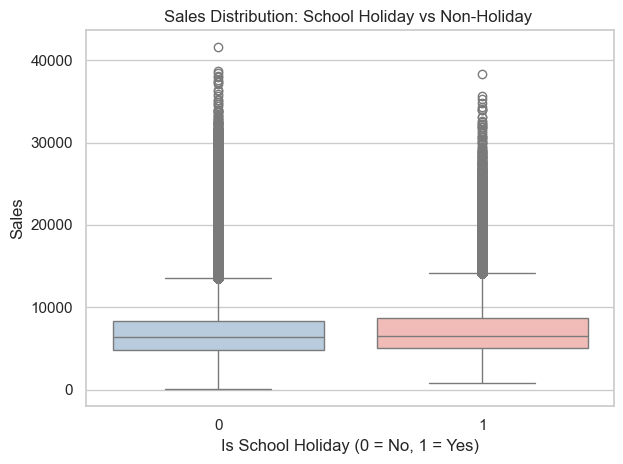

In [50]:

custom_palette = ['#b3cde3', '#fbb4ae']  
sns.boxplot(x='IsSchoolHoliday', y='Sales', data=df, palette=custom_palette)
plt.title('Sales Distribution: School Holiday vs Non-Holiday ')
plt.xlabel('Is School Holiday (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

#### Average sales on school holidays 

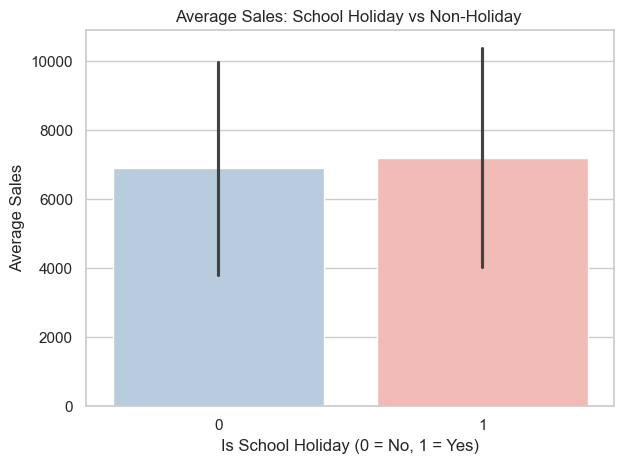

In [51]:
sns.barplot(x='IsSchoolHoliday', y='Sales', data=df, estimator='mean', ci='sd', palette=custom_palette)
plt.title('Average Sales: School Holiday vs Non-Holiday ')
plt.xlabel('Is School Holiday (0 = No, 1 = Yes)')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

## Section 6: Feature interactions
---
---

### Promotional strategy

#### Promo × StoreType -> Sales (Open Days Only)

- This boxplot examines how Promo campaigns influence sales on open days only, isolating the effect of promotions from store closures.

- All store types (A, B, C, D) show a similar increase in median sales during promotions (Promo == 1), indicating that promotions have a broad, consistent positive impact across store types.

  - Store Type C exhibits the most compact distributions, suggesting more predictable and stable promo-driven performance.

  - Store Type B, despite high overall sales, shows the widest spread and substantial overlap between promotional and non-promotional periods. This implies less consistency in promo effectiveness across stores in this group.

    - The substantial variability in Store Type B could be due to store-level differences (e.g., location, size, demographics), and may benefit from more targeted promotional planning.

- These findings support the use of promotions across all store types, but suggest store-specific factors should be considered — particularly for Type B, where outcomes vary most.

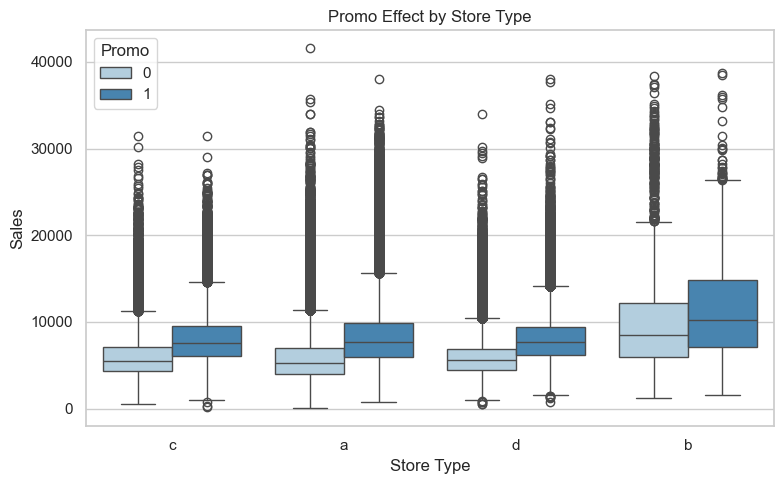

In [52]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df, 
    x='StoreType', 
    y='Sales', 
    hue='Promo', 
    palette='Blues'  # Cool blue theme for promotional strategy
)
plt.title('Promo Effect by Store Type')
plt.ylabel('Sales')
plt.xlabel('Store Type')
plt.legend(title='Promo')
plt.tight_layout()
plt.show()

#### Promo × Assortment -> Sales 

- This boxplot analyzes how promotional campaigns (Promo) affect sales across different assortment levels on days when stores are open.

  - All assortment levels — basic (a), extra (b), and extended (c) — show a positive shift in median sales during promotion periods (Promo == 1), suggesting that promotions generally improve sales across the board.

    - Basic assortment (a) and extended assortment (c) show the clearest and most consistent promo gain, with a noticeable upward shift in the median and limited overlap between promo and non-promo distributions. This indicates that promotions are highly effective in stores with narrow product ranges.

    - Extra assortment (b) stores have high baseline sales and show minimal separation between promo and non-promo periods. 
  
      - The variety level of (b) may already be optimal for its customers (a happy medium between the basic and extended assortments), meaning a promotion would only have a limited effect on an already strong level of sales. 

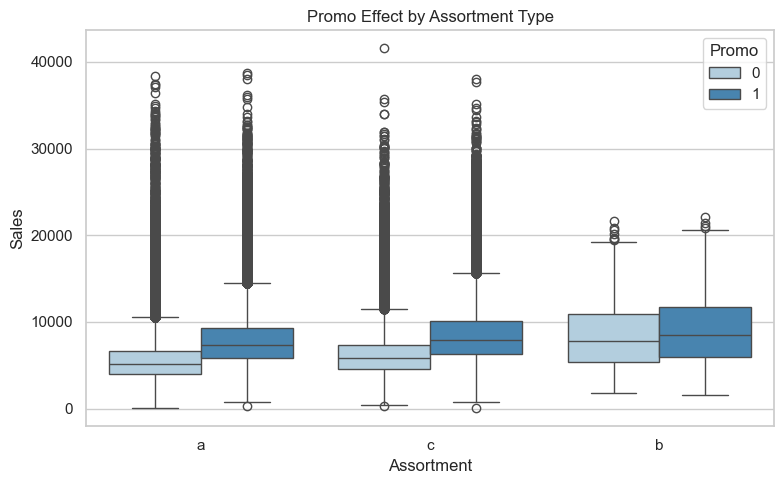

In [53]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df, 
    x='Assortment', 
    y='Sales', 
    hue='Promo', 
    palette='Blues'  # Keep consistent with the promotional theme
)
plt.title('Promo Effect by Assortment Type')
plt.ylabel('Sales')
plt.xlabel('Assortment')
plt.legend(title='Promo')
plt.tight_layout()
plt.show()

#### Promo × DayOfWeek -> Sales 

- NOTE: No promotional campaigns are recorded on Saturdays or Sundays in the dataset. They are included here to show the general pattern of sales throughout the week. 

- The plot shows average sales by day of week, separated by promo status, using only days when stores were open.

  - Among weekdays, Monday (Day 0) shows the largest uplift in average sales during promotions.

  - Days 1–4 (Tuesday to Friday) also benefit from promos, though the gap is less dramatic.

  - Weekends (Days 5–6) show strong baseline sales without any active promotions, with Sunday being the higher-earning day by a significant margin. 

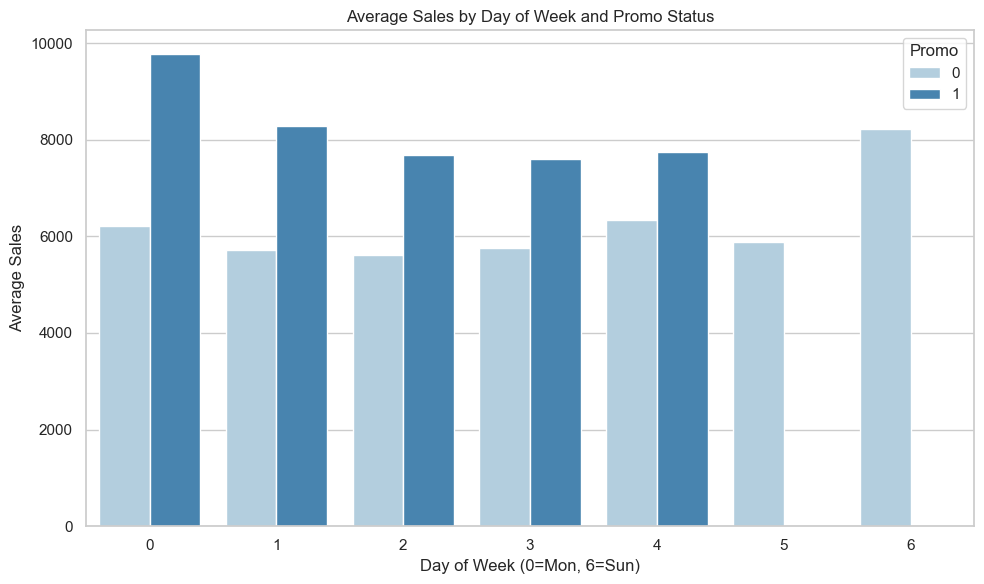

In [54]:
# Group and average
grouped = df.groupby(['Promo', 'DayOfWeek'])['Sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='DayOfWeek', y='Sales', hue='Promo', palette='Blues')

plt.title('Average Sales by Day of Week and Promo Status')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Average Sales')
plt.legend(title='Promo')
plt.tight_layout()
plt.show()

#### Promo2 × Month -> Sales 

- For all months, Promo2 stores underperform compared to non-Promo2 stores in terms of average sales.
  
- Promo2 strategy might need reevaluation — it appears to be consistently detrimental.

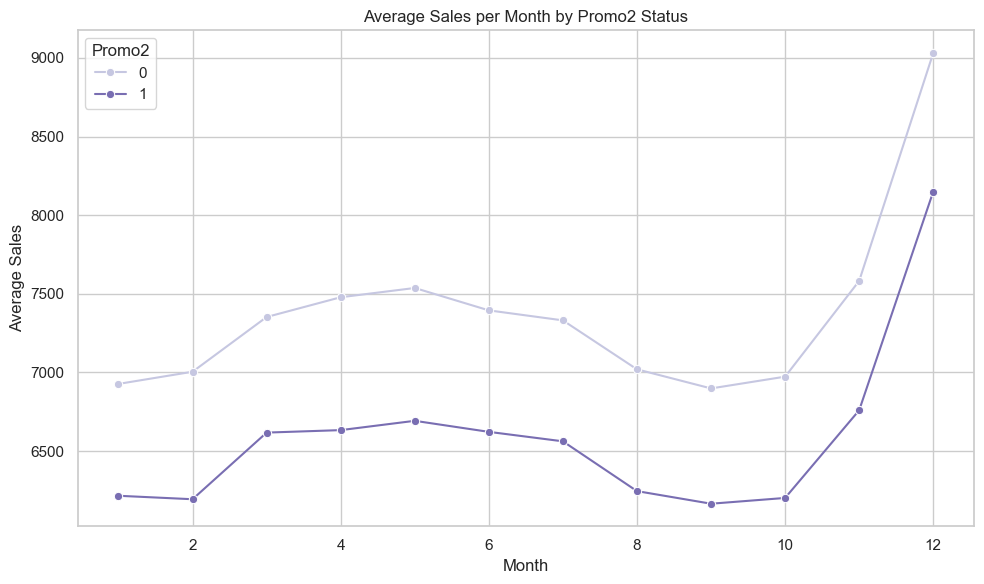

In [55]:
# Group and average sales by Month and Promo2
grouped = df.groupby(['Month', 'Promo2'])['Sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='Month', y='Sales', hue='Promo2', marker='o', palette='Purples')

plt.title('Average Sales per Month by Promo2 Status')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.legend(title='Promo2')
plt.tight_layout()
plt.show()

### Store characteristics

#### StoreType x CompetitionDistance -> Sales 

- This boxplot explores how sales performance varies by store format (a, b, c, d) depending on how close competitors are, using binned CompetitionDistance. Lighter green indicates nearby rivals, while darker green means distant competitors.

- Across all store types, stores tend to perform better when competitors are closer, contrary to typical assumptions:

  - The lightest green boxes (closest competition) generally have higher medians than darker shades.

  - This suggests proximity may boost foot traffic or place stores in denser commercial zones, rather than harming performance.

- Store Type b:

  - Shows the strongest positive response to nearby competition.

  - Median sales drop significantly as distance from competitors increases, with the darkest green (farthest) showing lowest sales.

  - Possibly reliant on being clustered with other retailers.

- Store Types a, c, and d:

  - All follow a similar trend—closer competition correlates with higher sales, although less dramatically than Type b.

  - Type d has the most similar performance across all distances, indicating it is not an important factor for this store type. 

- Rather than being cannibalized by nearby stores, these formats may be complemented by competitive presence.

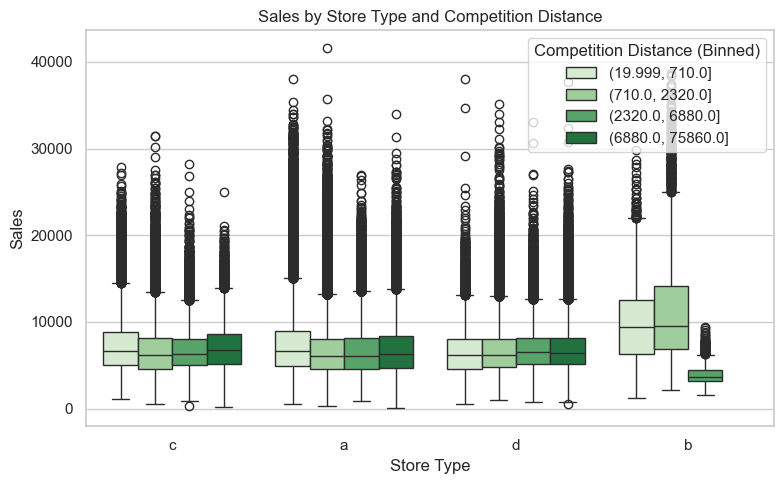

In [56]:
# Optional: bin distances
df['CompetitionBin'] = pd.qcut(df['CompetitionDistance'], q=4, duplicates='drop')

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df, 
    x='StoreType', 
    y='Sales', 
    hue='CompetitionBin', 
    palette='Greens'
)
plt.title('Sales by Store Type and Competition Distance')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.legend(title='Competition Distance (Binned)', loc='upper right')
plt.tight_layout()
plt.show()

df = df.drop(columns=["CompetitionBin"])

#### StoreType x Assortment -> Sales 

- NOTE: Assortment b is only available within store type b. 

- This boxplot examines how sales distribution varies by store format (StoreType) and assortment strategy (Assortment), providing insight into which combinations deliver stronger performance. Note: Not all combinations are represented—Assortment B only exists within Store Type B. As such, we only compare Assortment B to other assortments within Store Type B, not across other store types.

- Assortment C is the clear winner across all store types. 

- Store type b dominates overall:

  - Shows the highest median sales among all Store Types. 

  - The strongest performing combination is store Type b + Assortment c, which leads all groups in median and upper quartile performance by a wide margin.

  - Assortment b within store type b performs significantly worse, with notably lower median sales—suggesting this assortment strategy underperforms even within a strong store format.

- Store types a, c, and d:

  - Perform similarly across assortment types, with minimal differences in median sales.

  - These formats show broad, flat performance with no standout combinations, indicating they’re possibly less sensitive to assortment variations.

- All store types (especially a, c, d) exhibit long upper tails, showing that a subset of stores can still achieve high sales regardless of format or assortment.

- Store Type B stands out by combining both high median performance and less spread, which suggests consistent strength, not just a few outlier stores.

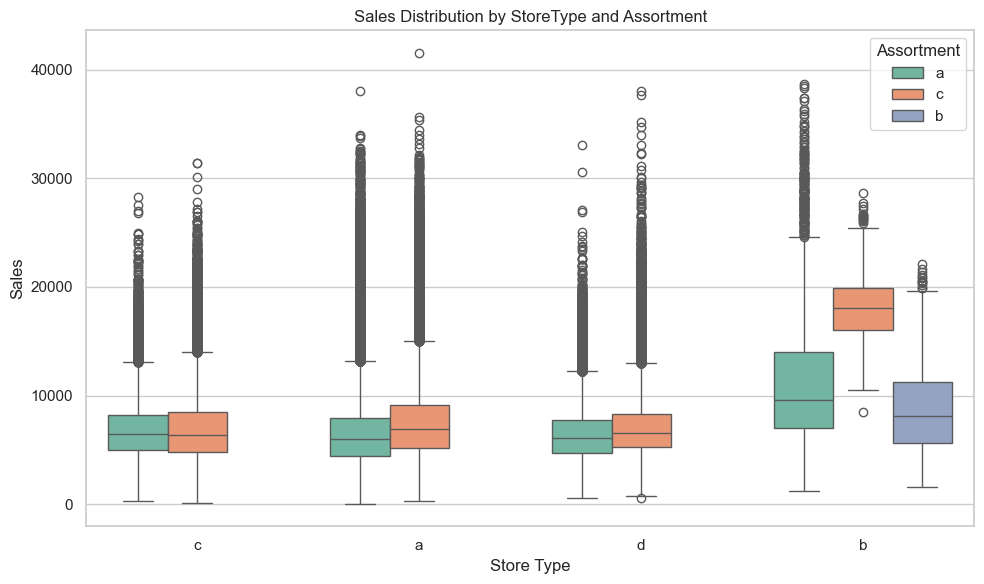

In [57]:
plt.figure(figsize=(10, 6))

# Create a grouped boxplot of Sales by StoreType and Assortment
sns.boxplot(
    data=df,
    x='StoreType',
    y='Sales',
    hue='Assortment',
    palette='Set2'  # Optional: visually distinct, pleasant colors
)

plt.title('Sales Distribution by StoreType and Assortment')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.legend(title='Assortment')
plt.tight_layout()
plt.show()


#### Assortment × Month -> Sales 

- NOTE: Assortment b is only available within store type b. 
   
- This line plot shows normalized average sales per store by assortment and month, revealing per-store performance patterns over time.

  - Assortment b consistently outperforms a and c across all months, confirming its strength seen in the boxplot (within store type b). 

  - Assortment c trails behind b, despite appearing stronger in the boxplot. Its wider distribution across store types likely inflates its aggregate presence, not per-store effectiveness.

  - Assortment a shows the lowest normalized sales, reaffirming its weak performance across both visualizations.

- All assortments decline sharply in August, then recover moderately in Q4 — though none return to mid-year highs.

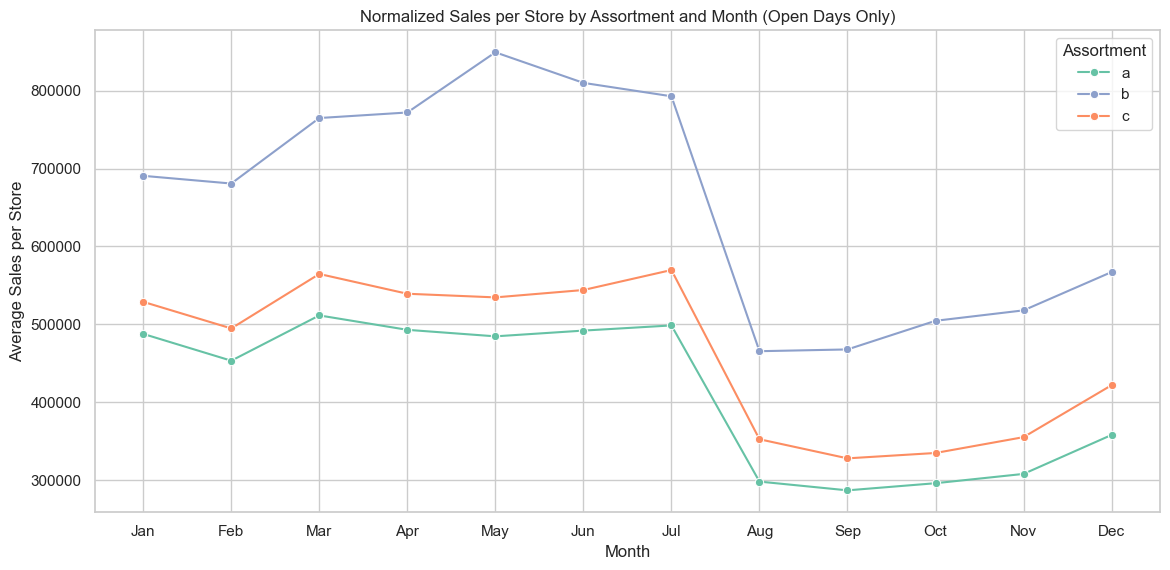

In [58]:
# Create complete Month-Assortment grid
all_months = list(range(1, 13))
all_assortments = df['Assortment'].unique()
full_index = pd.MultiIndex.from_product(
    [all_months, all_assortments],
    names=['Month', 'Assortment']
)
full_index_df = full_index.to_frame(index=False)

# Group original data
sales_per_group = (
    df.groupby(['Month', 'Assortment'])
    .agg(
        TotalSales=('Sales', 'sum'),
        StoreCount=('Store', 'nunique')
    )
    .reset_index()
)

# Merge with full grid to force missing Month-Assortment combos
sales_per_group = (
    full_index_df
    .merge(sales_per_group, on=['Month', 'Assortment'], how='left')
)

# Calculate sales per store
sales_per_group['SalesPerStore'] = sales_per_group['TotalSales'] / sales_per_group['StoreCount']

# Define custom color palette 
assortment_palette = {
    'a': '#66c2a5',  # green
    'b': '#8da0cb',  # blue
    'c': '#fc8d62'   # orange
}

# Reorder 'Assortment' as categorical to control legend order
sales_per_group['Assortment'] = pd.Categorical(
    sales_per_group['Assortment'],
    categories=['a', 'b', 'c'],
    ordered=True
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sales_per_group,
    x='Month',
    y='SalesPerStore',
    hue='Assortment',
    marker='o',
    palette=assortment_palette
)

plt.title('Normalized Sales per Store by Assortment and Month (Open Days Only)')
plt.xlabel('Month')
plt.ylabel('Average Sales per Store')
plt.xticks(ticks=range(1, 13), labels=calendar.month_abbr[1:13])
plt.tight_layout(pad=1.5)
plt.show()


## Section 7: Feature engineering 

- This section translates key EDA insights and domain context into model-ready features to improve learning performance and generalization. The engineering efforts fall into three main categories:

  - Continuous variable transformations
  
    - Log-transformed Sales and CompetitionDistance:
  
      - Applied log1p() to correct right-skewness and stabilize variance, which is  beneficial for tree-based models that rely on meaningful split thresholds.

    - Store-level average sales (Store_AvgSales):
  
      - Captures persistent sales strength of each store to help contextualize daily fluctuations in sales volume.

    - Label-encoded Month:
  
      - Converts calendar months into integer format for better model compatibility.

    - Engineered Holiday Anticipation Feature
  
      - IsPreStateHolidayWindow (3-day window before state holiday):
  
      - Designed to detect short-term sales shifts due to customer behavior before holidays. This bypasses the low utility of the raw StateHoliday field (most stores are closed on actual holidays) and tests whether demand increases just before closure.

      - After further analysis, this and other date-related features are dropped, but the entire process of creation and dropping it to show that this issue was considered (even if there is no resulting impact on modeling). 

- Interaction-based feature additions

  - Ordinal scores based on observed promo responsiveness for:

    - StoreType (promo_storetype_score)

    - Assortment (promo_assortment_score)

    - DayOfWeek (promo_day_strength)

    - Promo2 penalty flag (promo2_penalty) to capture underperformance linked to Promo2 strategy.

  - One-hot encoded interaction combos:

    - Promo × StoreType

    - Promo × Assortment

    - StoreType × Assortment

### Final feature adjustments - continuous / high-cardinality variables 

This cell performs final transformations to ensure model-readiness for key numeric and categorical features:

- Log-transform Sales and CompetitionDistance:
  
  - These variables exhibit heavy right skew. Applying a log(1+x) transformation reduces variance and stabilizes model learning, especially for tree-based regressors sensitive to wide ranges.

- Encode Month as an integer:

  - This completes the encoding of the other date-extracted features (Day, Week). The encoding for Month was delayed to facilitate analyses using this feature above, and is done now for modeling purposes. 

In [59]:
# Log-transform Sales (target)
df['Sales'] = np.log1p(df['Sales'])  # log(1 + x) to handle 0 sales

# Log-transform CompetitionDistance
df['CompetitionDistance'] = np.log1p(df['CompetitionDistance'])

# Encode Month column 
df['Month'] = le.fit_transform(df['Month'].astype(str))

### Engineer IsPreStateHolidayWindow feature

- As IsStateHoliday gives essentially the same information as Open (the above pots confirm that almost all stores are closed on state holidays), this column by itself isn't very useful. However, logically the anticipation of holidays can have an impact on customer behavior. 
  
- The new column IsPreStateHolidayWindow flags rows that are within a 3-week (21 day) period before a holiday. This helps us extract useful insight from the IsStateHoliday column without relying on it directly. 

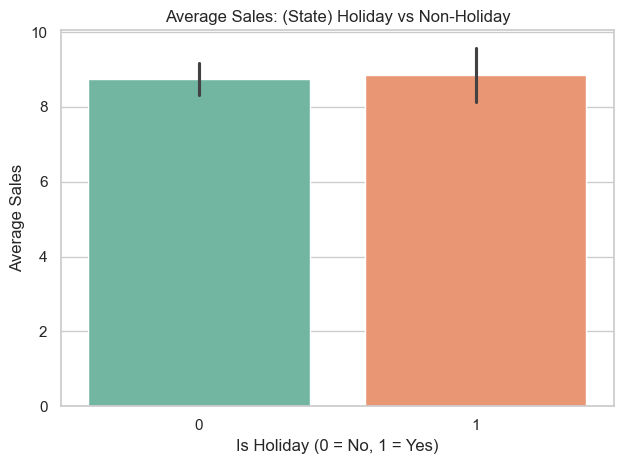

In [60]:
sns.barplot(x='IsStateHoliday', y='Sales', data=df, estimator='mean', ci='sd', palette='Set2')
plt.title('Average Sales: (State) Holiday vs Non-Holiday')
plt.xlabel('Is Holiday (0 = No, 1 = Yes)')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

In [61]:
# Sort by store and date to ensure proper windowing
df = df.sort_values(['Store', 'Date'])

# Create the feature
df['IsPreStateHolidayWindow'] = 0

# Set window length in days
pre_holiday_window = 21

# Get holiday dates per store
holiday_dates = df[df['IsStateHoliday'] == 1][['Store', 'Date']]

# Build lookup set for speed
holiday_lookup = (
    holiday_dates
    .assign(
        Start=lambda d: d['Date'] - pd.Timedelta(days=pre_holiday_window),
        End=lambda d: d['Date'] - pd.Timedelta(days=1)
    )
    .groupby('Store')
    .apply(lambda grp: list(zip(grp['Start'], grp['End'])))
    .to_dict()
)

# Define a function to check whether a row is within any store's pre-holiday windows
def is_in_preholiday_window(row):
    store = row['Store']
    date = row['Date']
    for start, end in holiday_lookup.get(store, []):
        if start <= date <= end:
            return 1
    return 0

# Apply row-wise
df['IsPreStateHolidayWindow'] = df.apply(is_in_preholiday_window, axis=1)


#### Impact of pre-holiday window (21 days before a state holiday) on Sales

In [62]:
# Calculate average sales for each category
avg_sales_normal = df[df['IsPreStateHolidayWindow'] == 0]['Sales'].mean()
avg_sales_preholiday = df[df['IsPreStateHolidayWindow'] == 1]['Sales'].mean()

print(f"Average Sales on Normal Days: {avg_sales_normal:.2f}")
print(f"Average Sales during Pre-Holiday Window: {avg_sales_preholiday:.2f}")


Average Sales on Normal Days: 8.76
Average Sales during Pre-Holiday Window: 8.89


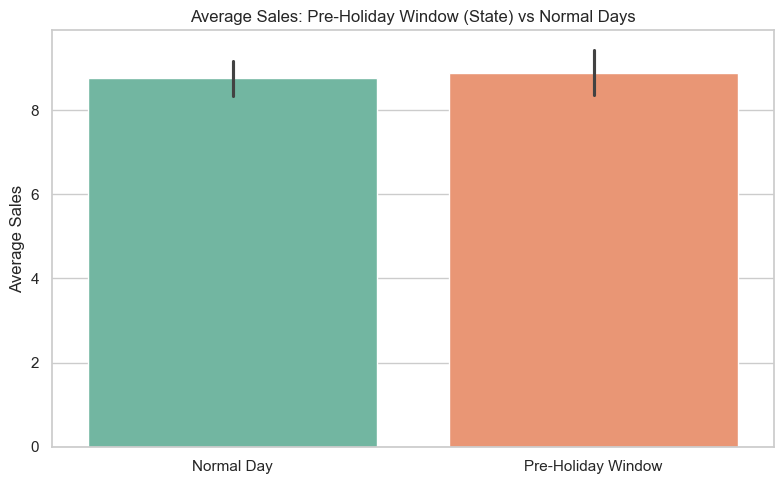

In [63]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df,
    x='IsPreStateHolidayWindow',
    y='Sales',
    estimator='mean',
    ci='sd',
    palette='Set2'
)
plt.xticks([0, 1], ['Normal Day', 'Pre-Holiday Window'])
plt.title('Average Sales: Pre-Holiday Window (State) vs Normal Days')
plt.xlabel('')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

#### Drop features related to state holidays

- Following this analysis, is is obvious that state holidays have no significant effect on sales in this dataset. Almost all holiday days coincide with store closures, and pre-holiday windows show no measurable sales gain. We therefore drop `StateHoliday`, `IsStateHoliday`, and `IsPreStateHolidayWindow` from the final dataset.

  - This makes sense when remembering that Rossmann is a drug store, which is less sensitive to holiday-based increases in demand (people don't stock up on medications for the holidays). 


In [64]:
# Drop holiday-related features after confirming they have no predictive value
df.drop(columns=['StateHoliday', 'IsStateHoliday', 'IsPreStateHolidayWindow'], inplace=True)

### Engineer ActiveStoreCount feature

- To adjust for variations in the number of reporting stores per day, a new feature, `ActiveStoreCount`, captures how many stores reported sales on each day and allows us to normalize sales accordingly. 
  
  - This helps mitigate distortions caused by partial data (during closures).


In [65]:
# Create ActiveStoreCount: number of stores reporting sales on each date
active_store_count = (
    df
    .groupby('Date')['Store']
    .nunique()
    .reset_index()
    .rename(columns={'Store': 'ActiveStoreCount'})
)

# Merge ActiveStoreCount into main dataframe
df = df.merge(active_store_count, on='Date', how='left')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  float64       
 4   Promo                      844338 non-null  int64         
 5   IsSchoolHoliday            844338 non-null  int64         
 6   StoreType                  844338 non-null  string        
 7   Assortment                 844338 non-null  string        
 8   CompetitionDistance        844338 non-null  float64       
 9   CompetitionOpenSinceMonth  844338 non-null  int64         
 10  CompetitionOpenSinceYear   844338 non-null  int64         
 11  Promo2                     844338 non-null  int64   

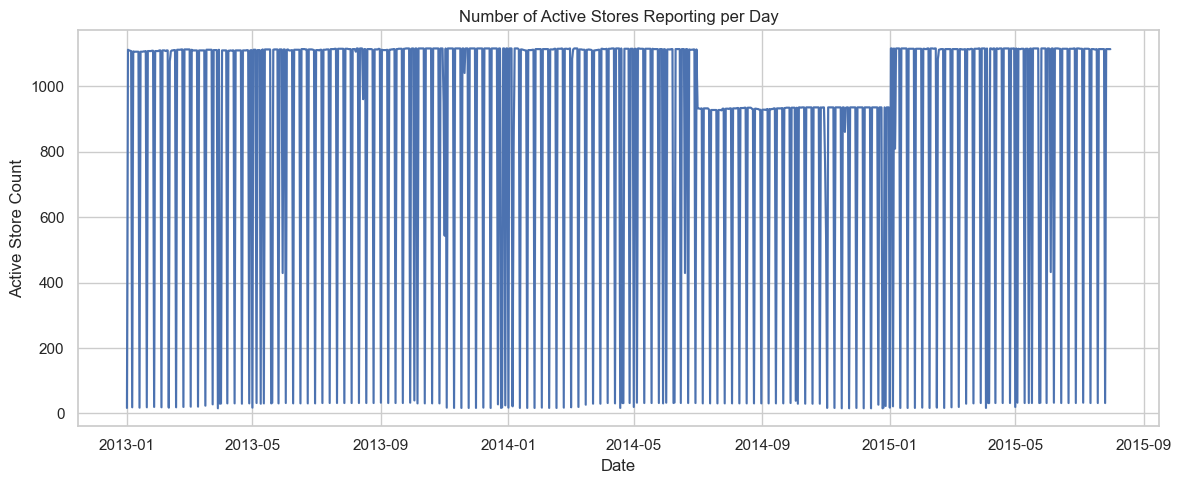

In [67]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='Date', y='ActiveStoreCount')
plt.title('Number of Active Stores Reporting per Day')
plt.xlabel('Date')
plt.ylabel('Active Store Count')
plt.tight_layout()
plt.show()

In [68]:
df.head()

,Store,DayOfWeek,Date,Sales,Promo,IsSchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,Week,IsWeekend,Promo2Start,Promo2DurationWeeks,CompetitionOpenSince,StoreStartDate,CompetitionOpenDuration,ActiveStoreCount
0,1,2,2013-01-02,8.62,0,1,c,a,7.15,11,15,0,50,-1,2013,0,11,0,0,NaT,0.00,2008-09-01,2013-01-02,52,1111
1,1,3,2013-01-03,8.37,0,1,c,a,7.15,11,15,0,50,-1,2013,0,22,0,0,NaT,0.00,2008-09-01,2013-01-02,52,1109
2,1,4,2013-01-04,8.41,0,1,c,a,7.15,11,15,0,50,-1,2013,0,25,0,0,NaT,0.00,2008-09-01,2013-01-02,52,1108
3,1,5,2013-01-05,8.52,0,1,c,a,7.15,11,15,0,50,-1,2013,0,26,0,1,NaT,0.00,2008-09-01,2013-01-02,52,1107
4,1,0,2013-01-07,8.88,1,1,c,a,7.15,11,15,0,50,-1,2013,0,28,11,0,NaT,0.00,2008-09-01,2013-01-02,52,1106


### New features based on interactions

These additions aim to capture sales-driving relationships between promotional activity, store format, product assortment, and temporal factors.

- Ordinal scores from observed promo sensitivity

  - `promo_storetype_score`
  
    - Reflects the observed consistency and strength of promotional effectiveness across different StoreType groups. 

  - `promo_assortment_score`
  
      - Scores each assortment level based on responsiveness to promotions. 

  - `promo_day_strength`
  
    - Assigns ordinal values to DayOfWeek based on how strongly promotions influenced sales by weekday. 

- Promo2 underperformance indicator
  
  - `promo2_penalty`
  
    - Flags stores currently enrolled in Promo2, which consistently underperformed in the data. Treating this as a negative signal allows the model to down-weight expected gains when Promo2 == 1.

- One-hot encoded categorical interactions
  
  - Each of these interaction terms is one-hot encoded, allowing tree-based models to learn from categorical relationships without introducing noise from rare combinations.
  
    - `promo_x_storetype`
  
      - Captures how different StoreType values respond under promotion (Promo). For example, “1_b” denotes store type b under a promotion.

    - `promo_x_assortment`

      - Encodes the relationship between promotional periods and product assortment complexity (Assortment).

    - `store_assortment_combo`

      - A direct combination of StoreType and Assortment, designed to capture high-performing format-strategy pairings (example: store type b with assortment b).



In [69]:
# Promo effectiveness by StoreType (ordinal score)
promo_storetype_score_map = {
    'a': 2,  # stable uplift
    'b': 1,  # high variance
    'c': 2,
    'd': 2
}
df['promo_storetype_score'] = df['StoreType'].map(promo_storetype_score_map)

# Promo effectiveness by Assortment (ordinal score)
promo_assortment_score_map = {
    'a': 2,  # consistent gain
    'b': 1,  # minimal gain
    'c': 2
}
df['promo_assortment_score'] = df['Assortment'].map(promo_assortment_score_map)

# Promo effectiveness by DayOfWeek (ordinal score)
promo_day_strength_map = {
    0: 3,  # Monday
    1: 2,
    2: 1,
    3: 1,
    4: 1,
    5: 0,  # Saturday
    6: 0   # Sunday
}
df['promo_day_strength'] = df['DayOfWeek'].map(promo_day_strength_map)

# Promo2 penalty flag — underperformance indicator
df['promo2_penalty'] = df['Promo2']  # keep as binary 0/1

# Categorical Interaction Features + One-Hot Encoding

# Promo × StoreType interaction
df['promo_x_storetype'] = df['Promo'].astype(str) + "_" + df['StoreType']
promo_storetype_dummies = pd.get_dummies(df['promo_x_storetype'], prefix='promo_storetype')
df = pd.concat([df, promo_storetype_dummies], axis=1)
df.drop(columns='promo_x_storetype', inplace=True)

# Promo × Assortment interaction
df['promo_x_assortment'] = df['Promo'].astype(str) + "_" + df['Assortment']
promo_assortment_dummies = pd.get_dummies(df['promo_x_assortment'], prefix='promo_assortment')
df = pd.concat([df, promo_assortment_dummies], axis=1)
df.drop(columns='promo_x_assortment', inplace=True)

# StoreType × Assortment combo
df['store_assortment_combo'] = df['StoreType'] + "_" + df['Assortment']
store_assortment_dummies = pd.get_dummies(df['store_assortment_combo'], prefix='store_assortment')
df = pd.concat([df, store_assortment_dummies], axis=1)
df.drop(columns='store_assortment_combo', inplace=True)

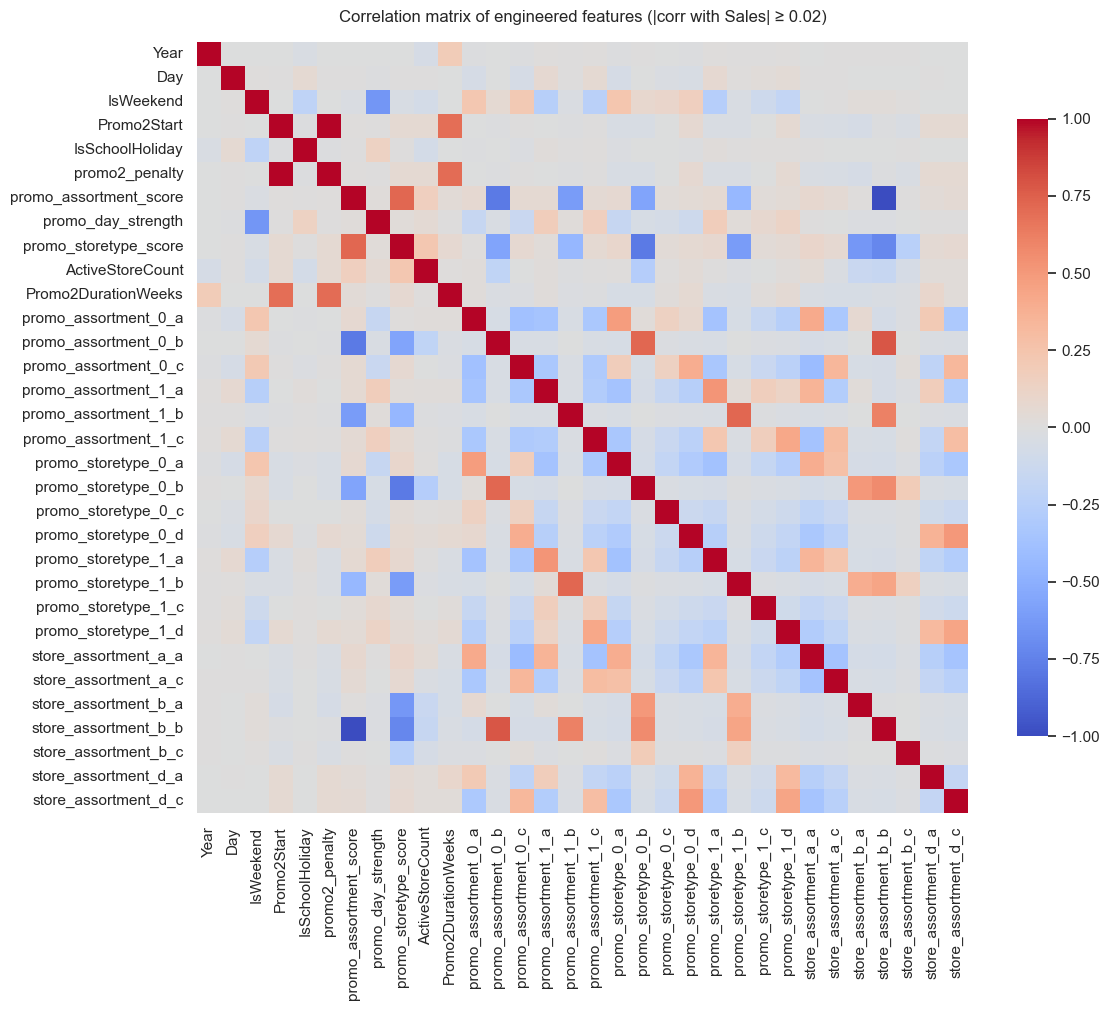

In [82]:
# Define your full engineered feature list
engineered_features = [
    'promo_assortment_0_a', 'Month', 'store_assortment_a_a', 'promo_storetype_0_a',
    'promo_assortment_1_a', 'store_assortment_b_c', 'StoreStartDate', 'promo_storetype_1_b',
    'IsWeekend', 'store_assortment_a_c', 'promo2_penalty', 'promo_storetype_0_d',
    'promo_storetype_1_d', 'Promo2Start', 'promo_assortment_score', 'Year',
    'store_assortment_c_c', 'promo_storetype_1_a', 'store_assortment_d_a', 'Week',
    'store_assortment_b_a', 'promo_assortment_0_b', 'ActiveStoreCount', 'promo_assortment_1_b',
    'promo_assortment_1_c', 'promo_storetype_1_c', 'Promo2DurationWeeks', 'CompetitionOpenDuration',
    'CompetitionOpenSince', 'store_assortment_d_c', 'store_assortment_b_b', 'promo_storetype_0_c',
    'Day', 'promo_day_strength', 'promo_assortment_0_c', 'promo_storetype_score',
    'IsSchoolHoliday', 'promo_storetype_0_b', 'store_assortment_c_a'
]

# --- Manually assign to categories ---
temporal = [
    "Month", "Year", "Week", "Day", "IsWeekend", "StoreStartDate", "Promo2Start", "CompetitionOpenSince"
]

binary_flags = [
    "IsSchoolHoliday"
]

ratios_and_scores = [
    "promo2_penalty", "promo_assortment_score", "promo_day_strength",
    "promo_storetype_score", "ActiveStoreCount", "Promo2DurationWeeks", "CompetitionOpenDuration"
]

# Everything else is assumed to be one-hot/categorical
remaining = list(set(engineered_features) - set(temporal) - set(binary_flags) - set(ratios_and_scores))
one_hot_encoded = sorted(remaining)

# Combine in order
ordered_cols = temporal + binary_flags + ratios_and_scores + one_hot_encoded

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
target_col = "Sales"          # Replace with your actual target column name
min_corr = 0.02               # Minimum absolute correlation to keep a feature

# --- Compute correlation with target ---
# Ensure target is in the DataFrame
assert target_col in df.columns, f"{target_col} not found in df.columns"

# Get correlations of engineered features with the target
target_corr = df[ordered_cols + [target_col]].corr()[target_col].drop(target_col)

# Filter features with sufficient correlation (absolute value)
selected_features = target_corr[abs(target_corr) >= min_corr].index.tolist()

# --- Final correlation matrix of selected features only ---
filtered_df = df[selected_features]
filtered_corr = filtered_df.corr()

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    filtered_corr,
    cmap="coolwarm",
    square=True,
    annot=False,
    cbar_kws={"shrink": 0.8},
    xticklabels=selected_features,
    yticklabels=selected_features,
    ax=ax
)

ax.set_title(f"Correlation matrix of engineered features (|corr with {target_col}| ≥ {min_corr})", pad=14)
ax.set_xticklabels(selected_features, rotation=90)
ax.set_yticklabels(selected_features, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
print(engineered_features)

['promo_assortment_0_a', 'Month', 'store_assortment_a_a', 'promo_storetype_0_a', 'promo_assortment_1_a', 'store_assortment_b_c', 'StoreStartDate', 'promo_storetype_1_b', 'IsWeekend', 'store_assortment_a_c', 'promo2_penalty', 'promo_storetype_0_d', 'promo_storetype_1_d', 'Promo2Start', 'promo_assortment_score', 'Year', 'store_assortment_c_c', 'promo_storetype_1_a', 'store_assortment_d_a', 'Week', 'store_assortment_b_a', 'promo_assortment_0_b', 'ActiveStoreCount', 'promo_assortment_1_b', 'promo_assortment_1_c', 'promo_storetype_1_c', 'Promo2DurationWeeks', 'CompetitionOpenDuration', 'CompetitionOpenSince', 'store_assortment_d_c', 'store_assortment_b_b', 'promo_storetype_0_c', 'Day', 'promo_day_strength', 'promo_assortment_0_c', 'promo_storetype_score', 'IsSchoolHoliday', 'promo_storetype_0_b', 'store_assortment_c_a'] 



In [71]:
# Final summary of processed dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 52 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  float64       
 4   Promo                      844338 non-null  int64         
 5   IsSchoolHoliday            844338 non-null  int64         
 6   StoreType                  844338 non-null  string        
 7   Assortment                 844338 non-null  string        
 8   CompetitionDistance        844338 non-null  float64       
 9   CompetitionOpenSinceMonth  844338 non-null  int64         
 10  CompetitionOpenSinceYear   844338 non-null  int64         
 11  Promo2                     844338 non-null  int64   

## Section 8: EDA conclusion

### Export processed dataset for modeling 

In [72]:
# Export cleaned DataFrame for modeling
df.to_csv("../data/data_processed.csv", index=False)

### Summary

- With the exploratory data analysis complete, we now have a well-understood, cleaned, and feature-engineered dataset ready for modeling. 
  
- Key insights include strong temporal trends, meaningful interactions between assortment types and store formats, and potential benefits from proximity to competitors. 
  
- Anomalies and missing values have been addressed systematically, continuous features have been transformed to mitigate outlier effects, and new features have been created to capture business-relevant patterns.

- We now proceed to the modeling phase in **02_Modeling.ipynb**.